In [1]:
import cvxpy as cp
import numpy as np
import os
import pickle
import re
import scipy
import seaborn as sns

from itertools import product
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

In [2]:
# Load the data
data_dir = "../data/AAMAS"
dset_idx = 3
which_dset = "00037-0000000%d.cat" % dset_idx

dset_sizes = [(201, 613), (161, 442), (667, 526)]
# Yes, maybe, no answer, no
# rating_scores = [1.0, .5, 0.0, -1.0]
rating_scores = [1.0, .5, 0.0, 0.01]

if dset_idx == 3:
    # Yes, maybe, no, conflict
    rating_scores = [1.0, .5, 0.01, 0.0]
#     rating_scores = [1.0, .5, -1.0, 0.0]

agent_idx = 0
with open(os.path.join(data_dir, which_dset)) as f:
    ratings = np.zeros(dset_sizes[dset_idx-1])
    for l in f.readlines():
        if not l.startswith("#"):
            l = re.sub("[0-9]*: ", "", l)
            bracket_list = re.compile("\{[0-9, ]*\}|[0-9]+")
            lists = bracket_list.findall(l)
            if len(lists) != 4:
                print(lists)
                print(l)
                print("PROBLEM")
            for idx, list_of_prefs in enumerate(lists):
                if list_of_prefs != '{}':
                    list_of_prefs = re.sub("[\{\}]", "", list_of_prefs)
                    prefs = [int(x)-1 for x in list_of_prefs.split(",")]
                    ratings[agent_idx, prefs] = rating_scores[idx]
            agent_idx += 1

In [3]:
if dset_idx == 3:
    gen = np.random.default_rng(seed=0)
    ratings[ratings == 0.01] = np.where(gen.random(ratings[ratings == 0.01].shape) < .98, 0, ratings[ratings == 0.01])

In [58]:
np.sum(ratings == 0.01)/ratings.size

0.01916817256770854

In [59]:
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
np.save(os.path.join(data_dir, "ratings_%d.npy" % dset_idx), ratings)

In [61]:
# Binarize the labels
binary_ratings = ratings.copy()

In [62]:
binary_ratings[ratings > .1] = 1

<Axes: ylabel='Count'>

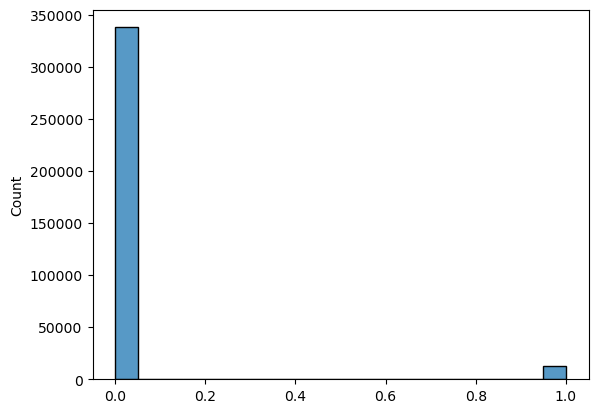

In [63]:
sns.histplot(binary_ratings.flatten())

In [64]:
gen = np.random.default_rng(seed=0)

In [65]:
# TODO: We can apply a mask to have a held-out test set
test_frac = .2
coi_mask = np.load(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx))
coi_mask = np.ones_like(coi_mask)
held_out_for_test = gen.random(binary_ratings.shape) < coi_mask*(binary_ratings > 0)*test_frac

In [66]:
np.sum(held_out_for_test)

3952

In [67]:
import torch
n_rows, n_cols = binary_ratings.shape
k = 20
U = torch.tensor(gen.normal(size=(n_rows, k)), requires_grad=True)
V = torch.tensor(gen.normal(size=(k, n_cols)), requires_grad=True)

# X = torch.tensor(gen.normal(size=(n_rows, n_cols)), requires_grad=True)
# y = torch.tensor(gen.normal(size=(n_rows, n_cols)), requires_grad=True)

In [68]:
observed_ones = np.where((1-held_out_for_test)*(binary_ratings > .9)*coi_mask)
observed_minus_ones = np.where((1-held_out_for_test)*(binary_ratings < .1)*(binary_ratings > 0)*coi_mask)

In [69]:
xe_loss = torch.nn.CrossEntropyLoss()

In [70]:
# loss = -torch.sum(torch.log(torch.special.expit(X[observed_ones])))
# loss = -torch.sum(torch.log(torch.special.expit(1-X[observed_minus_ones])))
# loss = xe_loss(X[observed_ones], torch.ones(X[observed_ones].shape))
# # loss += 0.1 * cp.norm(X, 'nuc')
# loss += .1 * torch.trace(torch.sqrt(X.T @ X))

step_size = .1
optimizer = torch.optim.Adam([U, V], lr=step_size)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

In [71]:
for i in tqdm(range(int(3001))):
    optimizer.zero_grad()
    x_pred = torch.special.expit(torch.mm(U, V))
    tgt_ones = torch.ones(ratings[observed_ones].shape).to(torch.long)
    loss = xe_loss(torch.concat((-x_pred[observed_ones].reshape((-1,1)), x_pred[observed_ones].reshape((-1, 1))), axis=1), tgt_ones)
    tgt_zeros = torch.zeros(ratings[observed_minus_ones].shape).to(torch.long)
    loss += xe_loss(torch.concat((-x_pred[observed_minus_ones].reshape((-1,1)), x_pred[observed_minus_ones].reshape((-1, 1))), axis=1), tgt_zeros)
    loss += .0005*torch.norm(U)
    loss += .0005*torch.norm(V)
#     loss = xe_loss(torch.concat((y[observed_ones].reshape((1, -1)), X[observed_ones].reshape((1, -1))), axis=0).T, torch.ones(X[observed_ones].shape).to(torch.long))
# #     loss += xe_loss(X[observed_minus_ones], torch.zeros(X[observed_minus_ones].shape))
#     loss += xe_loss(torch.concat((y[observed_minus_ones].reshape((1, -1)), X[observed_minus_ones].reshape((1, -1))), axis=0).T, torch.zeros(X[observed_minus_ones].shape).to(torch.long))

#     loss = -torch.sum(torch.log(torch.special.expit(1-X[observed_minus_ones])))
    # loss += 0.1 * cp.norm(X, 'nuc')
#     loss += .1 * torch.trace(torch.sqrt(torch.mm(X.T, X)))
    if i % 1000 == 0:
        print(loss)

    loss.backward()
    optimizer.step()
#     scheduler.step(loss)

  0%|          | 0/3001 [00:00<?, ?it/s]

tensor(1.8677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.9142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.9141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.9141, dtype=torch.float64, grad_fn=<AddBackward0>)


In [72]:
pred_mat = torch.special.expit(torch.mm(U, V))

<Axes: ylabel='Count'>

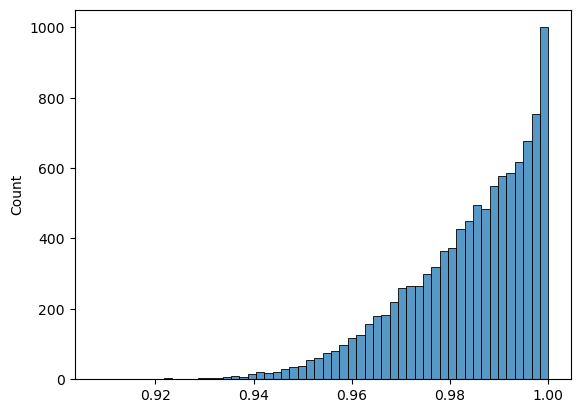

In [73]:
sns.histplot(pred_mat[observed_ones].flatten().detach().numpy())

<Axes: ylabel='Count'>

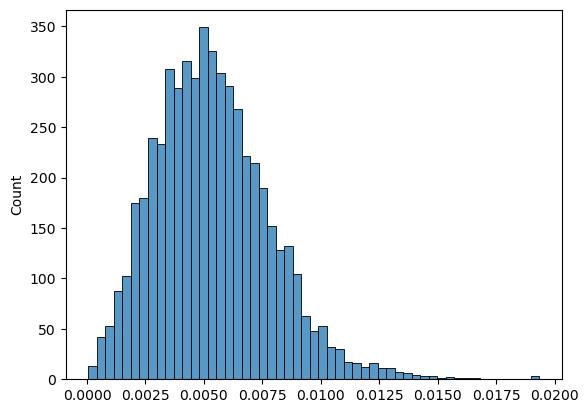

In [74]:
sns.histplot(pred_mat[observed_minus_ones].flatten().detach().numpy())

<Axes: ylabel='Count'>

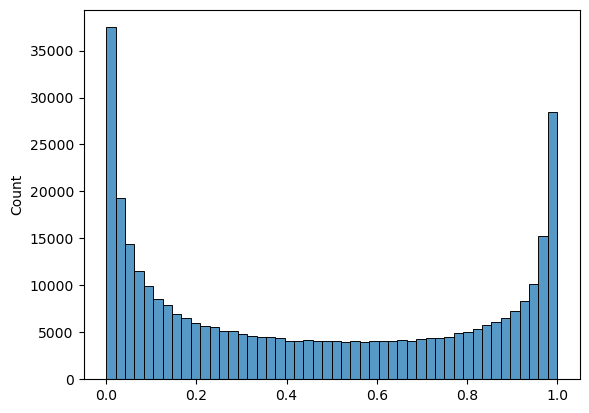

In [75]:
sns.histplot(pred_mat.flatten().detach().numpy())

In [76]:
# Now compute the bound on the cross entropy loss for each group under each delta value
groups = np.load(os.path.join(data_dir, "groups_%d.npy" % dset_idx))
coi_mask = np.load(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx))
coi_mask = np.ones_like(coi_mask)

In [77]:
# For each group, pull out the entries that were held out. Then compute mean and standard deviation of cross entropy loss
ngroups = len(set(groups))

means = []
stds = []

nonaggloss = torch.nn.CrossEntropyLoss(reduction='none')

for gidx in range(ngroups):
    cm = coi_mask[:, np.where(groups==gidx)[0]]
    test_entries = binary_ratings[:, np.where(groups == gidx)[0]]
    predictions = pred_mat[:, np.where(groups == gidx)[0]]
    observed_entries = np.where((np.abs(test_entries) > 0)*cm)
    print(observed_entries[0].shape)
#     print(test_entries[observed_entries])
#     print(predictions[observed_entries])
    tgt = test_entries[observed_entries]
    tgt[tgt == .01] = 0
    tgt = torch.tensor(tgt, dtype=int)
    
    p = predictions[observed_entries]
    p0 = torch.reshape(1-p, (-1,1))
    p1 = torch.reshape(p, (-1,1))
    preds_tensor = torch.concat((p0, p1), 1)
#     print(preds_tensor)
    preds_tensor = torch.log(preds_tensor)
#     print(preds_tensor.shape)
    
    xe_test = nonaggloss(preds_tensor, tgt)
    xe_test = xe_test.detach().cpu().numpy()
    
    mean, std = np.mean(xe_test), np.std(xe_test, ddof=1)
    print(mean, std)
    means.append(mean)
    stds.append(std)
#     print(test_entries.shape)

(4559,)
0.15735632980616657 0.6314297228541574
(7761,)
0.12409143570796845 0.530393492428167
(3701,)
0.15032288922430406 0.5702536641905267
(3622,)
0.16830934890622795 0.6399701441786327


In [78]:
n_groups = len(set(groups))

delta_to_normal_bd = {}
for delta in [.3, .2, .1, .05, .01]:
    delta_to_normal_bd[delta] = []
    for gidx in range(n_groups):
        ub = scipy.stats.norm.ppf(1-(delta/n_groups), loc=means[gidx], scale=stds[gidx])
        delta_to_normal_bd[delta].append(ub)
#     xis.append(xe_test.item())

In [79]:
delta_to_normal_bd

{0.3: [1.0663192875406737,
  0.8876095600392727,
  0.9712209852445375,
  1.0895665119123912],
 0.2: [1.1959657996077904,
  0.9965110954398971,
  1.0883066970504587,
  1.2209665616991086],
 0.1: [1.394935845368423,
  1.1636435785015937,
  1.2679995330897347,
  1.4226277826772538],
 0.05: [1.5726446329023107,
  1.312916856340376,
  1.428491007567666,
  1.6027401756539466],
 0.01: [1.9298008841937604,
  1.6129238794636407,
  1.7510441811289044,
  1.9647271543475073]}

In [80]:
np.save(os.path.join(data_dir, "prob_up_%d.npy" % dset_idx), pred_mat.detach().numpy())

In [81]:
pickle.dump(delta_to_normal_bd, open(os.path.join(data_dir, "delta_to_normal_bd_%d.pkl" % dset_idx), 'wb'))

In [82]:
np.save(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx), coi_mask)

In [362]:
def compute_group_egal_linear(a_l, b_l, phat_l, C_l, rhs_bd_per_group, loads, covs_lb_l, covs_ub_l, milp=False):
    ngroups = len(phat_l)
    model = gp.Model()

    t = model.addVar(lb=-gp.GRB.INFINITY, ub=gp.GRB.INFINITY,vtype=gp.GRB.CONTINUOUS, name='t')

    e_vals = []
    c_vals = []
    f_vals = []
    x_vals = []
    Allocs = []

    for gdx in range(ngroups):
        n_agents = phat_l[gdx].shape[0]
        n_items = phat_l[gdx].shape[1]
        phat = phat_l[gdx].flatten()
        C = C_l[gdx].flatten()
        covs_lb = covs_lb_l[gdx].flatten()
        covs_ub = covs_ub_l[gdx].flatten()

        A_multiplier = (a_l[gdx] - b_l[gdx])
        if milp==False:
            A = model.addMVar(len(phat_l[gdx].flatten()),lb=0, ub=1, vtype=gp.GRB.CONTINUOUS, name='Alloc' + str(gdx))
        else:
            A = model.addMVar(len(phat_l[gdx].flatten()),lb=0, ub=1, vtype=gp.GRB.INTEGER, name='Alloc' + str(gdx))
        Allocs.append(A)

        eps = 1e-6

        log_p_phat = np.log(phat).flatten()
        log_one_minus_phat = np.log(1-phat).flatten()
        rhs_bd = rhs_bd_per_group[gdx]

        mn = int(n_agents*n_items)
        c_val = np.sum(C)

        e = -1.0 * (c_val * rhs_bd + np.sum(C*log_one_minus_phat))
        neg_ones = -1*np.ones(mn)
        c= np.vstack((np.array([e]).reshape(1,1),neg_ones.flatten().reshape(-1,1))).flatten()
        f =  C*(log_p_phat - log_one_minus_phat).flatten()

        x = model.addMVar(mn+1, lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="pval")
        e_vals.append(e)
        c_vals.append(c)
        f_vals.append(f)
        x_vals.append(x)

        model.addConstrs(A[i] <= C[i] for i in range(mn))

        model.addConstrs(gp.quicksum(A[jdx * n_items + idx] for jdx in range(n_agents)) <= covs_ub[idx] for idx in
                         range(n_items))

        model.addConstrs(gp.quicksum(A[jdx * n_items + idx] for jdx in range(n_agents)) >= covs_lb[idx] for idx in
                         range(n_items))

        model.addConstrs((f[jdx]*x[0] - x[jdx+1] <= A_multiplier*A[jdx]/n_items   for jdx in range(mn)),name='ctr'+ str(gdx))
        model.addConstr(t<= c@x, name='min_w'+ str(gdx))

    load_sum = model.addMVar(loads.size, lb=0, ub=gp.GRB.INFINITY, obj=0.0, vtype=gp.GRB.CONTINUOUS, name='load_sum')

    model.addConstrs(load_sum[idx] == gp.quicksum(
        Allocs[gdx][idx * phat_l[gdx].shape[1]:(idx + 1) * (phat_l[gdx].shape[1])].sum() for gdx in range(ngroups)) for
                     idx in range(loads.size))
    total_agents = loads.size
    model.addConstrs(load_sum[idx] <= loads[idx] for idx in range(total_agents))

    model.setObjective(t, gp.GRB.MAXIMIZE)
    model.setParam('OutputFlag', 1)

    model.optimize()
    final_allocs = []
    for idx in range(ngroups):
        final_allocs.append(Allocs[idx].X)

    obj = model.getObjective()

    return final_allocs, obj.getValue()

In [428]:
selected_revs = gen.choice(range(pred_mat.shape[0]), int(.1*pred_mat.shape[0]))
selected_paps = gen.choice(range(pred_mat.shape[1]), int(.1*pred_mat.shape[1]))

In [429]:
coi_mask = np.load(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx))
coi_mask = np.ones_like(coi_mask)

In [430]:
small_pred_mat = pred_mat[selected_revs, :][:, selected_paps].detach().numpy()
small_coi = coi_mask[selected_revs, :][:, selected_paps]
small_groups = groups[selected_paps]
phat_l = []
C_l = []
cov_l = []

for gidx in range(4):
    phat_l.append(small_pred_mat[:, small_groups == gidx])
    C_l.append(small_coi[:, small_groups == gidx])
    cov_l.append(np.array([2]*np.sum(small_groups == gidx)))

In [431]:
compute_group_egal_linear([1]*4, [0]*4, phat_l, C_l, [0.9394841194775468,
  0.8941658975527695,
  0.990867096534835,
  1.0065408293391225], np.array([10]*small_pred_mat.shape[0]), cov_l, cov_l, milp=False)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7104 rows, 6935 columns and 27596 nonzeros
Model fingerprint: 0x459b46a8
Coefficient statistics:
  Matrix range     [4e-04, 5e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 5410 rows and 1926 columns
Presolve time: 0.00s
Presolved: 1694 rows, 5009 columns, 13160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    2118    2.0284932e-01   0.000000e+00   0.000000e+00      0s

Solved in 2118 iterations and 0.08 seconds (0.12 work units)
Optimal objective  2.028493191e-01


([array([3.77152655e-02, 7.44672753e-02, 0.00000000e+00, 0.00000000e+00,
         5.28135966e-02, 8.71094340e-03, 1.31477056e-02, 2.09679842e-01,
         1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 1.22864364e-02, 0.00000000e+00,
         1.28183978e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         6.86780948e-02, 1.81270243e-02, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         5.71231072e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.40873454e-02,
         0.00000000e+00, 4.32310389e-01, 0.00000000e+00, 1.00000000e+00,
         5.49571671e-03, 0.00000000e+00, 2.15865441e-02, 2.32347558e-02,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.05623827e-02,
         0.00000000e+00, 7.15424398e-02, 9.46164808

In [49]:
# Use https://dl.acm.org/doi/pdf/10.1145/1553374.1553452 to get prob model for CVaR objectives
gen = np.random.default_rng(seed=0)
q = 20
x = gen.normal(loc=0, scale=1e-3, size=(ratings.shape[0], q))
sig = .05

In [50]:
x

array([[ 1.25730221e-04, -1.32104863e-04,  6.40422650e-04, ...,
        -3.16300156e-04,  4.11630536e-04,  1.04251337e-03],
       [-1.28534663e-04,  1.36646347e-03, -6.65194673e-04, ...,
        -1.29613634e-04,  7.83975470e-04,  1.49343115e-03],
       [-1.25906553e-03,  1.51392377e-03,  1.34587542e-03, ...,
         6.96042724e-04, -1.18411797e-03, -6.61702572e-04],
       ...,
       [-9.02690927e-04,  9.37403974e-04,  9.56067063e-04, ...,
         1.11817382e-03, -1.54199682e-04,  2.54180358e-05],
       [ 2.62712982e-04,  2.24919949e-04,  8.63618968e-05, ...,
         4.42117853e-04,  9.69861933e-04, -1.11241352e-03],
       [-7.35110772e-04, -5.93191918e-04,  1.13752576e-04, ...,
        -7.00356874e-04, -4.90968554e-04, -1.48581079e-03]])

In [51]:
n_iter = 100

lr = 1e-4

for i in tqdm(range(n_iter)):
#     item_idx = gen.integers(ratings.shape[1])
    for item_idx in range(ratings.shape[1]):
        # pick out the users where this item was rated
        observed = np.where(np.abs(ratings[:, item_idx]) > 1e-4)[0]
#         print(observed)
#         print(x[observed])
        if len(observed):
            Cj = np.matmul(x[observed], x[observed].T) + (sig**2)*np.eye(len(observed))
#             print(Cj)
            Cinv = np.linalg.inv(Cj)
            yobs = ratings[observed, item_idx]
    #         print(yobs)
            G = np.outer(yobs, yobs)
            G = np.matmul(Cinv, G)
            G = np.matmul(G, Cinv)
            G -= Cinv
            grad = np.matmul(-G, x[observed])

            x[observed] -= lr*grad

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
# For each item, we can sample the rating for each user. It is by section 3.1, the prediction of user rating section.
print(x.shape)
k = np.matmul(x, x.T)
s = k + (sig**2)*np.eye(k.shape[0])
mu_matrix = np.zeros(ratings.shape)
zeta_matrix = np.zeros(ratings.shape)
for item_idx in tqdm(range(ratings.shape[1])):
    for user_idx in range(ratings.shape[0]):
        observed = np.where(np.abs(ratings[:, item_idx]) > 1e-4)[0]
        sobs = s[observed, :][:, observed]
        final_s = np.matmul(np.linalg.inv(sobs), k[observed, user_idx])
        mu = np.dot(final_s, ratings[observed, item_idx])
        mu_matrix[user_idx, item_idx] = mu
        zeta_matrix[user_idx, item_idx] = k[user_idx, user_idx] + sig**2 - np.dot(k[observed, user_idx], final_s)
        
# cov_mat = np.matmul(x, x.T) + (sig**2)*np.eye(x.shape[0])
# zero_vec = np.zeros(x.shape[0])

(667, 20)


  0%|          | 0/526 [00:00<?, ?it/s]

In [53]:
mu_clip = np.clip(mu_matrix, 0.01, np.inf)

In [54]:
np.save(os.path.join(data_dir, "mu_matrix_%d.npy" % dset_idx), mu_clip)
np.save(os.path.join(data_dir, "zeta_matrix_%d.npy" % dset_idx), zeta_matrix)

<Axes: ylabel='Count'>

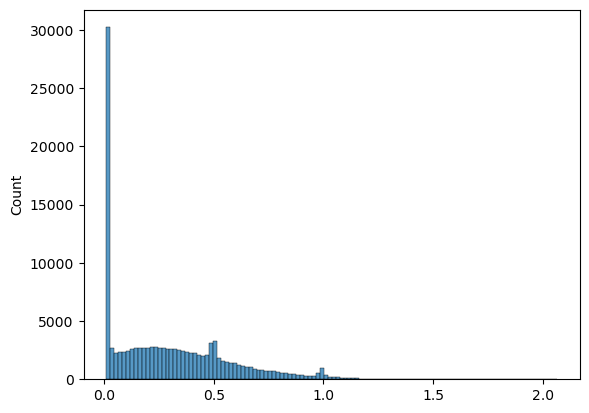

In [30]:
sns.histplot(mu_clip.flatten())

In [ ]:
sns.histplot(ratings)

In [93]:
ratings[np.where(ratings > .5)].shape

(6665,)

In [27]:
mu_matrix[np.where(ratings == 0)][:300]

array([-3.44743393e-02,  4.80575670e-01,  1.11181519e-01,  7.59777031e-02,
       -3.03729649e-01,  3.60396689e-01,  1.93732704e-01,  2.17760964e-01,
        5.34678932e-01,  7.11279997e-01, -1.75210142e-01, -2.06758990e-01,
        1.27380184e-03, -1.08767938e-01,  3.21916933e-01,  2.03067477e-01,
       -4.40233034e-02,  9.45189765e-04,  6.57881574e-01,  1.97885525e-01,
        2.37025261e-02,  2.09750614e-02, -2.12702208e-01,  2.38080129e-01,
        8.81078964e-04,  1.24246407e-01, -3.14513130e-01,  2.53858993e-01,
       -2.34617846e-02,  3.01153893e-01,  1.04454758e-01,  1.65490021e-01,
        1.44901340e-01,  5.81783103e-03,  7.26996098e-03, -2.10852725e-02,
        1.12216769e-01, -1.44412913e-02,  1.04061563e-01,  3.62168359e-01,
        1.02167135e-01,  1.33747886e-02,  9.29277549e-02,  3.72145595e-01,
       -4.40703929e-01,  1.99156848e-01,  2.04590723e-01,  3.91129102e-01,
        9.80272937e-02,  2.66403744e-01,  1.54962682e-01,  4.34786472e-01,
        9.82317925e-02, -

<Axes: ylabel='Count'>

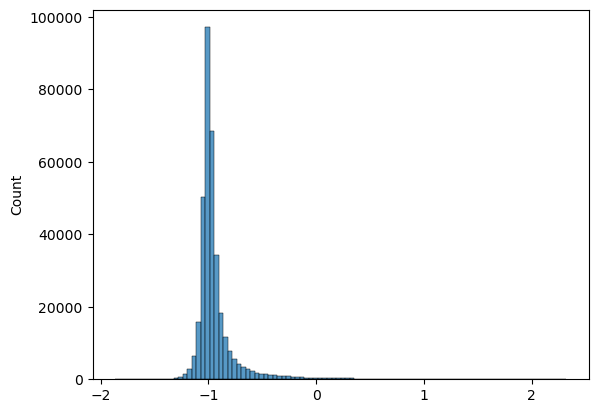

In [87]:
sns.histplot(mu_matrix.flatten(), bins=100)

<Axes: ylabel='Count'>

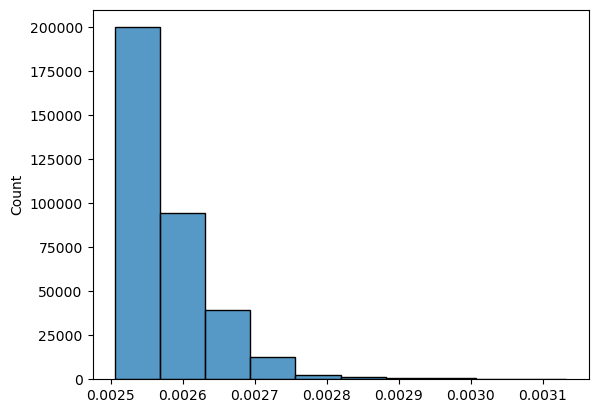

In [88]:
sns.histplot(zeta_matrix.flatten(), bins=10)

In [89]:
np.max(zeta_matrix, axis=0)

array([0.00296505, 0.00296334, 0.00296435, 0.00295996, 0.00295934,
       0.00296299, 0.00295931, 0.0029594 , 0.00296597, 0.00297264,
       0.00295932, 0.00296923, 0.00296814, 0.00295931, 0.00296012,
       0.00295932, 0.00296251, 0.00295974, 0.00296325, 0.00297145,
       0.00295931, 0.0030498 , 0.00295968, 0.00295931, 0.00297273,
       0.00295999, 0.00295989, 0.00296557, 0.0029594 , 0.00306311,
       0.00296902, 0.00296407, 0.00295937, 0.0029602 , 0.00296237,
       0.00296058, 0.00295931, 0.00295931, 0.00295931, 0.00295955,
       0.0029636 , 0.00295938, 0.00295931, 0.00296003, 0.00296141,
       0.00296319, 0.00296025, 0.00296027, 0.00296245, 0.00296156,
       0.00295938, 0.00296021, 0.00296334, 0.00295934, 0.00295954,
       0.00296074, 0.00295932, 0.00295931, 0.00296271, 0.00310144,
       0.00296818, 0.00295972, 0.00296031, 0.00295961, 0.00295976,
       0.00296168, 0.00295946, 0.00295964, 0.00295935, 0.0029677 ,
       0.0029684 , 0.00295998, 0.00296061, 0.00296353, 0.00297

# Now we'll cluster these and make groups for both getting COIs and for the GESW

In [346]:
# cluster ratings
dset_idx = 3
ratings = np.load(os.path.join(data_dir, "ratings_%d.npy" % dset_idx))

ratings[ratings < 0] = 0
ratings[ratings > 0] = 1

<Axes: ylabel='Count'>

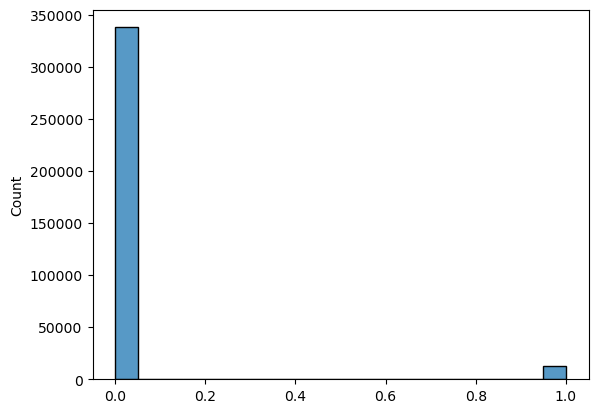

In [347]:
sns.histplot(ratings.flatten())

In [348]:
# from sklearn.cluster import SpectralBiclustering, KMeans
from scipy.spatial.distance import cdist
from sklearn.manifold import SpectralEmbedding
n, m = ratings.shape
affinities = np.zeros((n+m, n+m))
affinities[:n, :][:, n:] = ratings
affinities[n:, :][:, :n] = ratings.T
affinities += 1e-5
embedding = SpectralEmbedding(n_components=5, affinity='precomputed')
X_transformed = embedding.fit_transform(affinities)
# >>> X_transformed.shape
# clustering = SpectralBiclustering(n_clusters=4, random_state=1, method="log").fit(ratings)

In [349]:
X_transformed.shape

(1193, 5)

In [350]:
k=4
clusters = KMeans(n_clusters=k, random_state=0).fit(X_transformed)

In [351]:
rc = clusters.labels_[:n]
cc = clusters.labels_[n:]
print(Counter(rc), Counter(cc))

Counter({1: 404, 0: 138, 3: 72, 2: 53}) Counter({1: 289, 0: 145, 3: 59, 2: 33})


In [352]:
clusters.cluster_centers_

array([[-0.00476764,  0.00856899, -0.00025601,  0.00232498, -0.00056852],
       [ 0.00165742, -0.0029007 , -0.00056019, -0.0007972 , -0.00300265],
       [-0.00526398, -0.00877064, -0.00948956,  0.01381259,  0.01222643],
       [-0.00437072, -0.00204141,  0.00790982, -0.00963924,  0.01047929]])

In [353]:
import gurobipy as gp

In [354]:
# Iterate between assigning row and column cluster ids where each cluster must have at least a certain number of points,
# then recompute cluster centers.
centers = clusters.cluster_centers_
row_embs = X_transformed[:n]
col_embs = X_transformed[n:]

min_rc_size = int(.8*(n/k))
min_cc_size = int(.8*(m/k))

In [355]:
print(min_rc_size, min_cc_size)

133 105


In [356]:
for _ in range(100):
    # First we reassign with balance contraints
    row_dist_to_ctrs = cdist(row_embs, centers)
    col_dist_to_ctrs = cdist(col_embs, centers)
    
    m = gp.Model()

    matching_rows = m.addMVar(row_dist_to_ctrs.shape, vtype=gp.GRB.BINARY)
    matching_cols = m.addMVar(col_dist_to_ctrs.shape, vtype=gp.GRB.BINARY)
    
    m.addConstr(matching_rows.sum(axis=1) == 1)
    m.addConstr(matching_rows.sum(axis=0) >= min_rc_size)
    
    m.addConstr(matching_cols.sum(axis=1) == 1)
    m.addConstr(matching_cols.sum(axis=0) >= min_cc_size)

    obj = (matching_rows*row_dist_to_ctrs).sum() + (matching_cols*col_dist_to_ctrs).sum()

    m.setObjective(obj)
    m.optimize()
    
    print(obj.getValue())

    row_clusters = np.where(matching_rows.x)[1]
    col_clusters = np.where(matching_cols.x)[1]
    
    # Then we recompute cluster centers
    for cidx in range(k):
        row_pts = row_embs[np.where(row_clusters == cidx)[0], :]
        col_pts = col_embs[np.where(col_clusters == cidx)[0], :]
        centers[cidx] = np.mean(np.vstack((row_pts, col_pts)), axis=0)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x6aaeefaa
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-04, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 23.1191924
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 15.9842042
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 14.8954454

Root relaxation: objective 1.337727e+01, 677 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    


Root relaxation: objective 1.144977e+01, 798 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4497659   11.44977  0.00%     -    0s

Explored 1 nodes (798 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4498 12.0269 13.1713 19.7234 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.144976592236e+01, best bound 1.144976592236e+01, gap 0.0000%
11.44976592236025
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x2be539d2
Variable types: 0 continuous, 4772 integer (4772 bin


Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.04 seconds (0


*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows a

  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.14


Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heur

Presolve time: 0.03s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
T

11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Vari

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.03s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.0

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+0

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.03s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.

Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 co

Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @

11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Vari

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.0

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+0

In [357]:
Counter(row_clusters)

Counter({0: 133, 1: 268, 3: 133, 2: 133})

In [358]:
Counter(col_clusters)

Counter({1: 182, 2: 105, 0: 134, 3: 105})

In [359]:
np.save(os.path.join(data_dir, "groups_%d.npy" % dset_idx), col_clusters)

In [360]:
coi_mask = (np.reshape(col_clusters, (1,-1)) == np.reshape(row_clusters, (-1, 1))).astype(int)

In [361]:
np.sum(coi_mask)/coi_mask.size

0.2694318240119484

In [362]:
# np.sum(coi_mask, axis=0)

In [363]:
print(data_dir)

../data/AAMAS


In [364]:
np.save(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx), coi_mask)

In [391]:
k = 4
min_cluster_size = ratings.shape[0]//(k+1)
print(min_cluster_size)

row_clusters = KMeans(n_clusters=4, random_state=0).fit(ratings)
row_centers = row_clusters.cluster_centers_
distance_matrix = cdist(ratings, row_centers)
print(distance_matrix.shape)
# Now match each row to a column such that the total number of rows matching to columns is roughly equal.
m = gp.Model()

matching = m.addMVar(distance_matrix.shape, vtype=gp.GRB.BINARY)
m.addConstr(matching.sum(axis=1) == 1)
m.addConstr(matching.sum(axis=0) >= min_cluster_size)

obj = (matching*distance_matrix).sum()

m.setObjective(obj)
m.optimize()

row_clusters = np.where(matching.x)[1]

133
(667, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 671 rows, 2668 columns and 5336 nonzeros
Model fingerprint: 0x3a919a9e
Variable types: 0 continuous, 2668 integer (2668 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 5782.0563291
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 5405.9146928

Root relaxation: objective 4.970396e+03, 972 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [392]:
# Do the same for the columns
k = 4
min_cluster_size = ratings.shape[1]//(k+1)
print(min_cluster_size)

col_clusters = KMeans(n_clusters=4, random_state=0).fit(ratings.T)
col_centers = col_clusters.cluster_centers_
distance_matrix = cdist(ratings.T, col_centers)
print(distance_matrix.shape)
# Now match each row to a column such that the total number of rows matching to columns is roughly equal.
import gurobipy as gp
m = gp.Model()

matching = m.addMVar(distance_matrix.shape, vtype=gp.GRB.BINARY)
m.addConstr(matching.sum(axis=1) == 1)
m.addConstr(matching.sum(axis=0) >= min_cluster_size)

obj = (matching*distance_matrix).sum()

m.setObjective(obj)
m.optimize()

col_clusters = np.where(matching.x)[1]

105
(526, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 530 rows, 2104 columns and 4208 nonzeros
Model fingerprint: 0xe6f3e31b
Variable types: 0 continuous, 2104 integer (2104 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 5382.4332668
Presolve time: 0.01s
Presolved: 530 rows, 2104 columns, 4208 nonzeros
Variable types: 0 continuous, 2104 integer (2104 binary)
Found heuristic solution: objective 4943.1623742

Root relaxation: objective 4.601444e+03, 711 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [393]:
Counter(row_clusters)

Counter({1: 133, 2: 133, 0: 268, 3: 133})

In [394]:
Counter(col_clusters)

Counter({2: 105, 1: 105, 3: 211, 0: 105})

In [395]:
# Match up the row clusters with the column clusters. 
# For each pair of clusters, we take the submatrix corresponding to those rows and columns. We can then
# compute the average similarity. Then compute a maximum matching basically.
cluster_link_scores = np.zeros((k,k))
for ridx, cidx in product(range(k), range(k)):
    cluster_link_scores[ridx, cidx] = np.mean(ratings[row_clusters == ridx, :][:, col_clusters == cidx])
print(cluster_link_scores)

[[-0.98798863 -0.92800284 -0.95520611 -0.95800912]
 [-0.7075546  -0.96616541 -0.95363409 -0.95200086]
 [-0.9660222  -0.93161475 -0.7868242  -0.95061112]
 [-0.98191908 -0.77382743 -0.79817401 -0.96142608]]


In [396]:
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(-1*cluster_link_scores)

In [397]:
print(row_ind, col_ind)

[0 1 2 3] [3 0 2 1]


In [398]:
new_col_inds = row_ind[np.argsort(col_ind)]

In [399]:
remapped_col_clusters = [new_col_inds[i] for i in col_clusters]

In [400]:
Counter(remapped_col_clusters)

Counter({2: 105, 3: 105, 0: 211, 1: 105})

In [401]:
np.sum(ratings[:, 13] > .5)

21

In [402]:
ratings.shape

(667, 526)

In [403]:
np.save(os.path.join(data_dir, "groups_%d.npy" % dset_idx), remapped_col_clusters)

In [404]:
coi_mask = (np.reshape(remapped_col_clusters, (1,-1)) == np.reshape(row_clusters, (-1, 1))).astype(int)

In [405]:
np.sum(coi_mask)/coi_mask.size

0.28059069324653263

In [406]:
# np.sum(coi_mask, axis=0)

In [407]:
print(data_dir)

../data/AAMAS


In [408]:
np.save(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx), coi_mask)

In [412]:
import gurobipy as gp
m = gp.Model("TPMS")

mu_matrix = np.load("../data/AAMAS/mu_matrix_%d.npy" % dset_idx)
coi_mask = np.load("../data/AAMAS/coi_mask_%d.npy" % dset_idx)

cs = [3, 2, 2]
ls = [15, 15, 4]
covs_lb = cs[dset_idx-1] * np.ones(mu_matrix.shape[1])
covs_ub = covs_lb
loads = ls[dset_idx - 1] * np.ones(mu_matrix.shape[0])

covs_lb = np.minimum(covs_lb, np.sum(coi_mask, axis=0))


alloc = m.addMVar(mu_matrix.shape, vtype=gp.GRB.BINARY, name='alloc')

m.addConstr(alloc.sum(axis=0) >= covs_lb)
m.addConstr(alloc.sum(axis=0) <= covs_ub)
m.addConstr(alloc.sum(axis=1) <= loads)
m.addConstr(alloc <= coi_mask)

obj = (alloc*mu_matrix).sum()
m.setObjective(obj, gp.GRB.MAXIMIZE)

m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 352561 rows, 350842 columns and 1403368 nonzeros
Model fingerprint: 0x291b64d3
Variable types: 0 continuous, 350842 integer (350842 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective -890.3243179
Presolve removed 352082 rows and 294294 columns
Presolve time: 0.99s
Presolved: 479 rows, 56548 columns, 113096 nonzeros
Found heuristic solution: objective -216.0878651
Variable types: 0 continuous, 56548 integer (56548 binary)
Found heuristic solution: objective -187.9824425

Root relaxation: objective -1.249874e+02, 772 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |    

In [413]:
# np.sum(coi_mask, axis=0)
np.sum(alloc.x, axis=1)

array([0., 4., 4., 3., 2., 0., 4., 1., 4., 3., 0., 4., 4., 0., 0., 4., 4.,
       0., 0., 0., 4., 1., 0., 4., 0., 4., 0., 4., 1., 4., 4., 4., 0., 4.,
       4., 2., 4., 4., 4., 0., 2., 2., 4., 4., 0., 0., 4., 4., 4., 4., 4.,
       4., 4., 2., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 4., 0.,
       4., 4., 4., 0., 0., 4., 0., 0., 0., 0., 4., 0., 0., 4., 0., 0., 0.,
       0., 3., 4., 0., 0., 1., 0., 1., 0., 0., 4., 4., 0., 0., 4., 0., 4.,
       0., 4., 4., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 1., 0., 4., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 4., 3., 0., 4., 4., 4.,
       0., 4., 0., 0., 4., 4., 4., 0., 0., 0., 0., 0., 4., 0., 4., 1., 0.,
       4., 0., 4., 0., 2., 4., 0., 4., 4., 2., 0., 4., 0., 0., 4., 0., 4.,
       0., 4., 0., 0., 4., 4., 4., 0., 4., 0., 0., 0., 0., 4., 0., 0., 4.,
       4., 0., 0., 4., 4., 0., 0., 4., 0., 3., 0., 1., 3., 0., 4., 1., 4.,
       1., 0., 4., 4., 0., 1., 4., 3., 0., 0., 4., 4., 4., 0., 0., 0., 1.,
       4., 0., 0., 0., 4.

In [414]:
np.sum(coi_mask, axis=0)[:30]

array([133, 133, 268, 268, 133, 133, 268, 268, 133, 268, 268, 133, 133,
       133, 133, 268, 133, 133, 268, 268, 268, 268, 268, 133, 133, 133,
       268, 133, 268, 133])

In [416]:
np.sum(mu_matrix > 0)

4629

In [430]:
(alloc.x*mu_matrix)[np.where(alloc.x > .5)][:50]

array([ 0.7996833 ,  0.83835331,  1.12499062,  0.8914211 , -0.78597412,
       -0.73600691, -0.80784617, -0.84445602, -0.87994646, -0.51211886,
       -0.89839996,  0.30609427,  0.49783666,  0.15539555,  0.45517362,
       -0.03782739,  0.13930814,  0.76662682, -0.05363163,  0.15707378,
       -0.64195638,  0.61690283, -0.92971344, -0.87478012, -0.90458152,
        0.77843746,  0.53877998,  0.89484714,  1.08641038, -0.0951319 ,
        0.61434734,  0.44087165,  0.98100219,  0.73363947,  0.37858621,
        0.01480599,  0.43697855,  0.19224157,  0.13540374, -0.11962357,
        0.96458317,  0.9670202 ,  0.98330062,  1.91395501,  1.66754085,
       -0.72756361, -0.01379574, -0.18888704, -0.24075622, -0.24784361])

In [424]:
alloc.x[np.where(alloc.x > .5)]

array([1., 1., 1., ..., 1., 1., 1.])

<Axes: ylabel='Count'>

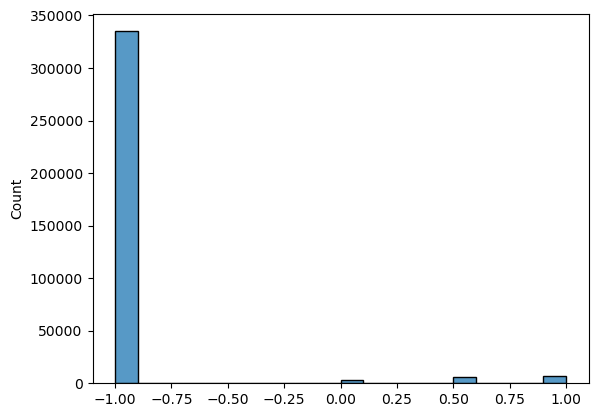

In [431]:
sns.histplot(ratings.flatten())

# Lets figure out what the uncertainty sets look like for each of these 3 conferences

In [439]:

dset_idx = 1
mu = np.load(os.path.join(data_dir, "mu_matrix_%d.npy" % dset_idx))
sig = np.load(os.path.join(data_dir, "zeta_matrix_%d.npy" % dset_idx))
cois = np.load(os.path.join())
print(mu, sig)

[[-1.31569881 -0.00919867 -0.12555626 ...  0.19952523 -0.99439887
  -1.26740124]
 [-0.95484462  0.11860635 -0.39883208 ... -1.02697241 -0.39235444
  -0.66807202]
 [ 0.65053973  0.64019915 -0.07734686 ...  0.70850634  0.51395934
   0.37788927]
 ...
 [-1.36444282 -0.46509636 -0.27187297 ... -0.39057497 -1.32326365
  -0.93794184]
 [ 0.22167786 -0.67683628 -0.04056618 ... -0.07078721 -0.65171542
   0.43151583]
 [ 0.92694799  0.4591538   0.34326559 ...  0.64727505  0.34926279
  -0.01433178]] [[0.30891302 0.2257526  0.04006468 ... 0.2056059  0.00485976 0.07579999]
 [0.32003912 0.17288503 0.05812096 ... 0.0841023  0.02968094 0.13725221]
 [0.0475679  0.05097059 0.00791566 ... 0.00680325 0.01853365 0.03743972]
 ...
 [0.21513276 0.27246977 0.01816245 ... 0.01986167 0.13211829 0.08669199]
 [0.10604284 0.08250018 0.00882556 ... 0.07418879 0.01917057 0.09500311]
 [0.03707423 0.05583834 0.00485573 ... 0.05823314 0.03374338 0.03176694]]


# Old code

In [167]:
# Use logistic matrix factorization to fill in the missing entries
n_rows, n_cols = binary_ratings.shape

X = cp.Variable((n_rows, n_cols))

observed_ones = np.where(binary_ratings > .9)
observed_minus_ones = np.where(binary_ratings < -.9)

loss = -cp.sum(cp.logistic(-X[observed_ones]))
loss -= cp.sum(cp.logistic(X[observed_minus_ones]))
loss -= 0.1 * cp.norm(X, 'nuc')

print(loss.is_dcp())

objective = cp.Maximize(loss)
problem = cp.Problem(objective)
problem.solve(solver=cp.MOSEK, verbose=True)

recovered_matrix = X.value

True
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) May 08 03:01:13 PM: Your problem has 123213 variables, 0 constraints, and 0 parameters.
(CVXPY) May 08 03:01:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 08 03:01:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 08 03:01:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 08 03:01:13 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 08 03:01:13 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Cons

Error: rescode.err_space(1051): 

In [193]:
def compute_adv_usw_ellipsoidal(allocation, central_estimate, std_devs, rhs_bd_per_group, groups):
    m = gp.Model()

    ngroups = len(set(groups))

    obj_terms = []

    for gidx in range(ngroups):
        print("setting up group ", gidx)
        gmask = np.where(groups == gidx)[0]

        a = allocation[:, gmask]
        ce = central_estimate[:, gmask]
        sd = std_devs[:, gmask]
        rhs_bd = rhs_bd_per_group[gidx]

        v = m.addMVar(ce.shape)

        m.addConstr(((v - ce)*(1/sd)*(v-ce)).sum() <= rhs_bd**2)

        m.addConstr(v >= 0)
        obj_terms.append((a * v).sum())
    obj = gp.quicksum(t for t in obj_terms)
    m.setObjective(obj)
    m.optimize()
    m.setParam('OutputFlag', 1)

    return obj.getValue()/allocation.shape[1]

In [207]:
ce = np.load("../data/AAMAS/mu_matrix_1.npy")
sd = np.load("../data/AAMAS/zeta_matrix_1.npy")
coi_mask = np.load("../data/AAMAS/coi_mask_1.npy")
# rhs_bd_per_group = pickle.load(open("../data/AAMAS/delta_to_normal_bd_1.pkl", 'rb'))[.3]
groups = np.load("../data/AAMAS/groups_1.npy")

rhs_bd_per_group = []
for gidx in range(ngroups):
    gmask = np.where(groups == gidx)[0]
    c_value = np.sum(coi_mask[:, gmask])
    rhs_bd_per_group.append(np.sqrt(chi2.ppf(1-(delta/ngroups), df=c_value)))
alloc = np.load("../outputs/outputs/gAAMAS1/adv_usw_0.20_alloc.npy")
compute_adv_usw_ellipsoidal(alloc, ce, sd, rhs_bd_per_group, groups)

setting up group  0
setting up group  1
setting up group  2
setting up group  3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 123213 rows, 123213 columns and 123213 nonzeros
Model fingerprint: 0xbe57536f
Model has 4 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-03, 5e-01]
  QLMatrix range   [6e-05, 8e-01]
  Objective range  [7e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [5e+03, 2e+04]
Presolve removed 123213 rows and 116602 columns
Presolve time: 0.14s
Presolved: 6619 rows, 6619 columns, 13234 nonzeros
Presolved model has 4 second-order cone constraints
Ordering time: 0.04s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 1.323e+04
 Factor NZ  : 2.148e+04 (roughly 6 MB of memory)


3.013447078713015e-05

In [196]:
ce = np.load("../data/AAMAS/mu_matrix_1.npy")

In [206]:
std_devs

array([0.14651901, 0.52671945, 0.17400819, 0.26309411, 0.38751302,
       0.14034449, 0.38047045, 0.92172342, 0.5644524 , 0.54597279,
       0.75329007, 0.47514043, 0.52005296, 0.90047282, 0.48707488,
       0.93570449, 0.42257889, 0.58435012, 0.57955509, 0.16759207,
       0.68294789, 0.2423659 , 0.80103377, 0.78771202, 0.3849937 ,
       0.75859168, 0.94976436, 0.24130725, 0.645074  , 0.38670197,
       0.35844322, 0.55719922, 0.10692755, 0.9206929 , 0.74018473,
       0.51995625, 0.22735842, 0.47111865, 0.25382722, 0.69614049,
       0.22572887, 0.91459622, 0.47578613, 0.86983051, 0.11406514,
       0.94967571, 0.58511537, 0.37904973, 0.66825598, 0.12386745,
       0.52241283, 0.96523034, 0.71347487, 0.90161739, 0.41059203,
       0.15044843, 0.52025008, 0.45687901, 0.37457616, 0.86414201,
       0.99562675, 0.714547  , 0.82659484, 0.84358849, 0.28643695,
       0.19061773, 0.45190152, 0.71249119, 0.32375542, 0.5761603 ,
       0.39130063, 0.19061063, 0.64960122, 0.97770019, 0.84633

# Aug 1. Load up the Gaussian AAMAS dataset. Is it the case that reviewers are being "fought over"? And that one group would better utilize them? Can we perhaps quantify this degree that reviewers are being "fought over" and show that GESW pulls ahead when this is the case?

Test this locally with just the naive solutions, then run the full experiment and report the full tables for all 3 *modified* datasets 

In [3]:
import sys
sys.path.append("../AllCode/src")
from allocation_code import solve_usw_gurobi, solve_gesw, solve_cvar_usw
from compute_allocations import get_samples
from metric_code import compute_usw, compute_gesw, compute_cvar_usw

In [4]:
mu = np.load("../data/AAMAS/mu_matrix_1.npy")
z = np.load("../data/AAMAS/zeta_matrix_1.npy")

In [5]:
mu

array([[0.01      , 0.48057567, 0.11118152, ..., 0.40093335, 0.02584049,
        0.11485965],
       [0.10929719, 0.01      , 0.28400038, ..., 0.15015605, 0.01637972,
        0.26716151],
       [0.14381512, 0.23318558, 0.46502575, ..., 0.58986287, 0.32453958,
        0.07434307],
       ...,
       [0.24883263, 0.1444028 , 0.01      , ..., 0.01      , 0.09924188,
        0.20975442],
       [0.08710326, 0.04161912, 0.05557775, ..., 0.12002591, 0.04356095,
        0.09154604],
       [0.35635097, 0.89820928, 0.20413389, ..., 0.93667811, 0.68044524,
        0.19403014]])

In [6]:
# Oh, can we just add groups with basically duplicate papers, but every score is lower? 
# Or maybe like duplicates on the top reviewers, but value is cut in half. Everything else is not really good. 
# Like you really need certain reviewers, but they do not appear to be as valuable to you as they are to others.
# We can just make one group where this is the case. Vary the size of the group, 
# the number of reviewers that have nonzero valuations, and the divisor that cuts the total value. Probably can show 3 plots
# that compare this, just for the base USW/GESW. Later we can do it for the robust and stochastic objectives.
# Let's just do 2 groups for now.
from copy import deepcopy
mod_mu = deepcopy(mu)

dset_idx = 0
cs = [3, 2, 2]
ls = [15, 15, 10]
covs_lb = cs[dset_idx] * np.ones(mod_mu.shape[1])
covs_ub = covs_lb
loads = ls[dset_idx] * np.ones(mod_mu.shape[0])
coi_mask = np.ones_like(mod_mu)
groups = np.zeros_like(covs_lb, dtype=np.int32)

divisor = 2
num_nonzero = 2
group_size = int(.3*covs_lb.shape[0])

print(divisor, num_nonzero, group_size)

gen = np.random.default_rng(seed=1)
sampled_papers = gen.choice(range(covs_lb.shape[0]), size=group_size)
# print(sampled_papers)
new_papers = deepcopy(mod_mu[:, sampled_papers])

for i in range(group_size):
    non_top_value_idxs = np.argsort(new_papers[:, i])[:-1*num_nonzero]
    new_papers[non_top_value_idxs, i] = 0
new_papers /= divisor
mod_mu = np.hstack((mod_mu, new_papers))
# print(mod_mu.shape)
# print(mod_mu)

# Change the covs, loads, groups too.
covs_lb = cs[dset_idx] * np.ones(mod_mu.shape[1])
covs_ub = covs_lb
loads = ls[dset_idx] * np.ones(mod_mu.shape[0])
coi_mask = np.ones_like(mod_mu)
groups = np.hstack((groups, np.ones(shape=(group_size,), dtype=np.int32)))

2 2 183


In [6]:
usw_alloc = solve_usw_gurobi(mod_mu, covs_lb, covs_ub, loads, coi_mask)
gesw_alloc = solve_gesw(mod_mu, covs_lb, covs_ub, loads, groups, coi_mask)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 161789 rows, 159996 columns and 639984 nonzeros
Model fingerprint: 0x6abe666d
Variable types: 0 continuous, 159996 integer (159996 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 560.0930155
Presolve removed 160792 rows and 0 columns
Presolve time: 0.65s
Presolved: 997 rows, 159996 columns, 319992 nonzeros
Variable types: 0 continuous, 159996 integer (159996 binary)
Found heuristic solution: objective 588.1519147

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj

In [52]:
print(compute_gesw(gesw_alloc, mod_mu, groups), compute_gesw(usw_alloc, mod_mu, groups))

0.9078911715535268 0.8171161475807384


In [73]:
def run_exp_to_get_usw_soln_loss_on_gesw(divisor, num_nonzero, group_size):
    num_nonzero = int(num_nonzero)
    group_size = int(group_size)
    print(divisor, num_nonzero, group_size)
    
    mod_mu = deepcopy(mu)

    dset_idx = 0
    cs = [3, 2, 2]
    ls = [15, 15, 10]
    covs_lb = cs[dset_idx] * np.ones(mod_mu.shape[1])
    covs_ub = covs_lb
    loads = ls[dset_idx] * np.ones(mod_mu.shape[0])
    coi_mask = np.ones_like(mod_mu)
    groups = np.zeros_like(covs_lb, dtype=np.int32)

    gen = np.random.default_rng(seed=1)
    sampled_papers = gen.choice(range(covs_lb.shape[0]), size=group_size)
    new_papers = deepcopy(mod_mu[:, sampled_papers])

    for i in range(group_size):
        non_top_value_idxs = np.argsort(new_papers[:, i])[:-1*num_nonzero]
        new_papers[non_top_value_idxs, i] = 0
    new_papers /= divisor
    mod_mu = np.hstack((mod_mu, new_papers))

    # Change the covs, loads, groups too.
    covs_lb = cs[dset_idx] * np.ones(mod_mu.shape[1])
    covs_ub = covs_lb
    loads = ls[dset_idx] * np.ones(mod_mu.shape[0])
    coi_mask = np.ones_like(mod_mu)
    groups = np.hstack((groups, np.ones(shape=(group_size,), dtype=np.int32)))
    
    usw_alloc = solve_usw_gurobi(mod_mu, covs_lb, covs_ub, loads, coi_mask)
    gesw_alloc = solve_gesw(mod_mu, covs_lb, covs_ub, loads, groups, coi_mask)
    
    gesw_from_usw_alloc = compute_gesw(usw_alloc, mod_mu, groups)
    gesw_from_gesw_alloc = compute_gesw(gesw_alloc, mod_mu, groups)
    
    return (gesw_from_gesw_alloc - gesw_from_usw_alloc)/gesw_from_gesw_alloc

In [56]:
divisor = 2
num_nonzero = 5
group_size = 150
print(run_exp_to_get_usw_soln_loss_on_gesw(divisor, num_nonzero, group_size))

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 155090 rows, 153363 columns and 613452 nonzeros
Model fingerprint: 0xcc379940
Variable types: 0 continuous, 153363 integer (153363 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 562.1468520
Presolve removed 154126 rows and 0 columns
Presolve time: 0.63s
Presolved: 964 rows, 153363 columns, 306726 nonzeros
Variable types: 0 continuous, 153363 integer (153363 binary)
Found heuristic solution: objective 593.8319465

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03      1s
    

In [70]:
divisor_options = np.arange(1, 20.1, 1)
num_nonzero_options = np.arange(1, 50.1, 5)
group_size_options = np.arange(50, 301, 20)
varying_divisors = []
varying_num_nonzero = []
varying_group_size = []


default_divisor = 2
default_num_nonzero = 5
default_group_size = 150

In [71]:
for do in tqdm(divisor_options):
    varying_divisors.append(run_exp_to_get_usw_soln_loss_on_gesw(do, default_num_nonzero, default_group_size))

  0%|          | 0/20 [00:00<?, ?it/s]

1.0 5 150
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 155090 rows, 153363 columns and 613452 nonzeros
Model fingerprint: 0x2dc57e45
Variable types: 0 continuous, 153363 integer (153363 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 568.0255915
Presolve removed 154126 rows and 0 columns
Presolve time: 0.59s
Presolved: 964 rows, 153363 columns, 306726 nonzeros
Variable types: 0 continuous, 153363 integer (153363 binary)
Found heuristic solution: objective 599.7106860

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03   



Root relaxation: objective 1.752152e+03, 34130 iterations, 0.68 seconds (0.47 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1752.1524286 1752.15243  0.00%     -    1s

Explored 1 nodes (34130 simplex iterations) in 1.74 seconds (1.41 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 1752.15 593.832 562.147 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.752152428561e+03, best bound 1.752152428561e+03, gap 0.0000%
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 01 05:02:06 PM: Your problem has 153364 variables, 5 constraints, and 0 parameters.
(CVXPY) Aug 01 05:02:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 01 05:02:06 PM: (If you need to solve

(CVXPY) Aug 01 05:02:16 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Aug 01 05:02:16 PM: Applying reduction FlipObjective
(CVXPY) Aug 01 05:02:16 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 01 05:02:16 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:02:16 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 01 05:02:17 PM: Applying reduction GUROBI
(CVXPY) Aug 01 05:02:17 PM: Finished problem compilation (took 6.219e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:02:17 PM: Invoking solver GUROBI  to obtain a solution.
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

No start values specified in MIP start

Found heuristic solution: objective -0.0195956
Presolve removed 154126 rows and 0 columns
Presolve time: 0.54s
Presolved: 966 rows, 153364 columns, 430691 nonzeros
Variable types: 1 continuous, 153363 integer (153363 binary)

Root relaxation: objective -7.312621e-01, 1519 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -0.7312621   -0.73126  0.00%     -    0s

Explored 1 nodes (1519 simplex iterations) in 0.88 seconds (0.90 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.731262 -0.0195956 

Optimal solution found (tolerance 1.00e-04)
Best objective -7.312620801735e-01, best bound -7.312620801735e-01, gap 0.0000%
---------------------------------------------------------

(CVXPY) Aug 01 05:02:38 PM: Optimal value: 5.850e-01
(CVXPY) Aug 01 05:02:38 PM: Compilation took 3.976e-01 seconds
(CVXPY) Aug 01 05:02:38 PM: Solver (including time spent in interface) took 3.038e+00 seconds
6.0 5 150
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 155090 rows, 153363 columns and 613452 nonzeros
Model fingerprint: 0xf434ad91
Variable types: 0 continuous, 153363 integer (153363 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 558.2276924
Presolve removed 154126 rows and 0 columns
Presolve time: 0.49s
Presolved: 964 rows, 153363 columns, 306726 nonzeros
Variable types: 0 continuous, 153363 integer (153363 binary)
Found heuris


    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03      1s
       1       1500   1.0019988e+09  -3.1405664e+03      1s
       2       3387   6.2199843e+08  -3.0367293e+03      1s
       3       5465   5.0499839e+08  -2.9648625e+03      1s
       4       7895   2.8399838e+08  -2.9269461e+03      1s
       5      10262   7.2998371e+07  -2.9070353e+03      1s
       6      12879  -1.6458556e+03  -2.6579296e+03      1s
       7      15016  -1.6475706e+03  -2.4871241e+03      1s
       8      17123  -1.6487009e+03  -2.4237197e+03      1s
       9      19471  -1.6497158e+03  -2.3610239e+03      1s
      10      21554  -1.6499441e+03  -2.2251808e+03      1s
      11      23512  -1.6523897e+03  -2.1670241e+03      1s
      12      25616  -1.6538095e+03  -2.0989272e+03      1s
      13      27708  -1.6564576e+03  -2.0232721e+03      1s
      14      29519  -1.6610339e+03  -1.9727573e+03      1s
      15      31459  -1.6651236e+03  -1

      18      36945  -1.7001241e+03  -1.7934709e+03      1s
      19      38485  -1.7007641e+03  -1.7602016e+03      1s
      20      40102  -1.7013102e+03  -1.7473537e+03      1s
      21      41828  -1.7014219e+03  -1.7346066e+03      1s
      22      43494  -1.7016680e+03  -1.7234268e+03      1s
      23      44979  -1.7017213e+03  -1.7123034e+03      2s
      24      46497  -1.7017265e+03  -1.7028382e+03      2s
      25      47942  -1.7017350e+03  -1.6952842e+03      2s
      26      49285  -1.7017350e+03  -1.6917777e+03      2s

Sifting complete


Root relaxation: objective 1.652893e+03, 50623 iterations, 0.89 seconds (0.83 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1652.8927947 1652.89279  0.00%     -    1s

Explored 1 nodes (50623 simplex iterations) in 1.77 seconds (1.76 work units)
Thread count was 8 (of 8 available processor


Optimal solution found (tolerance 1.00e-04)
Best objective 1.651433767899e+03, best bound 1.651433767899e+03, gap 0.0000%
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 01 05:03:08 PM: Your problem has 153364 variables, 5 constraints, and 0 parameters.
(CVXPY) Aug 01 05:03:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 01 05:03:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 01 05:03:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:03:08 PM: Compiling

(CVXPY) Aug 01 05:03:17 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Aug 01 05:03:17 PM: Applying reduction FlipObjective
(CVXPY) Aug 01 05:03:17 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 01 05:03:17 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:03:17 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 01 05:03:18 PM: Applying reduction GUROBI
(CVXPY) Aug 01 05:03:18 PM: Finished problem compilation (took 4.764e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:03:18 PM: Invoking solver GUROBI  to obtain a solution.
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]


Model fingerprint: 0xabe7c38b
Variable types: 1 continuous, 153363 integer (153363 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

No start values specified in MIP start

Found heuristic solution: objective -0.0071259
Presolve removed 154126 rows and 0 columns
Presolve time: 0.52s
Presolved: 966 rows, 153364 columns, 430691 nonzeros
Variable types: 1 continuous, 153363 integer (153363 binary)

Root relaxation: objective -2.659135e-01, 1514 iterations, 0.06 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -0.2659135   -0.26591  0.00%     -    0s

Explored 1 nodes (1514 simplex iterations) in 0.89 seconds (0.90 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.265913 -0.00712585

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:03:38 PM: Problem status: optimal
(CVXPY) Aug 01 05:03:38 PM: Optimal value: 2.438e-01
(CVXPY) Aug 01 05:03:38 PM: Compilation took 3.857e-01 seconds
(CVXPY) Aug 01 05:03:38 PM: Solver (including time spent in interface) took 3.054e+00 seconds
13.0 5 150
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 155090 rows, 153363 columns and 613452 nonzeros
Model fingerprint: 0x96802f31
Variable types: 0 continuous, 153363 integer (153363 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-04, 2e+00]
  Bounds rang

Found heuristic solution: objective 557.1079325
Presolve removed 154126 rows and 0 columns
Presolve time: 0.46s
Presolved: 964 rows, 153363 columns, 306726 nonzeros
Variable types: 0 continuous, 153363 integer (153363 binary)
Found heuristic solution: objective 588.7930269

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03      1s
       1       1500   1.0019988e+09  -3.1405664e+03      1s
       2       3387   6.2199843e+08  -3.0367293e+03      1s
       3       5453   5.1699840e+08  -2.9648625e+03      1s
       4       7583   3.2899839e+08  -2.9227259e+03      1s
       5      10145   1.1099838e+08  -2.9207242e+03      1s
       6      13507  -1.6420890e+03  -2.5364857e+03      1s
       7      15533  -1.6434810e+03  -2.4414289e+03      1s
       8      17652  -1.6446695e+03  -2.3733394e+03      1s
       9      19724  -1.6457006e+03  -2.1942515e+03      1s
      

      14      29571  -1.6571136e+03  -1.9420451e+03      1s
      15      31529  -1.6610371e+03  -1.9093627e+03      1s
      16      33367  -1.6637560e+03  -1.8743099e+03      1s
      17      35135  -1.6667578e+03  -1.8348794e+03      1s
      18      36963  -1.6685366e+03  -1.7981512e+03      1s
      19      38723  -1.6696155e+03  -1.7609137e+03      1s
      20      40418  -1.6703019e+03  -1.7437215e+03      1s
      21      42181  -1.6706857e+03  -1.7221802e+03      2s
      22      43633  -1.6708968e+03  -1.7102557e+03      2s
      23      45221  -1.6711124e+03  -1.7009663e+03      2s
      24      46693  -1.6711683e+03  -1.6892424e+03      2s
      25      48292  -1.6712591e+03  -1.6841025e+03      2s
      26      49697  -1.6712769e+03  -1.6767184e+03      2s
      27      51103  -1.6712792e+03  -1.6720816e+03      2s
      28      52555  -1.6712792e+03  -1.6689900e+03      2s

Sifting complete


Root relaxation: objective 1.647679e+03, 54034 iterations, 0.97 seconds (0.92 wo


*    0     0               0    1647.3987982 1647.39880  0.00%     -    1s

Explored 1 nodes (52811 simplex iterations) in 1.82 seconds (1.83 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 1647.4 588.688 557.003 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.647398798161e+03, best bound 1.647398798161e+03, gap 0.0000%
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 01 05:04:09 PM: Your problem has 153364 variables, 5 constraints, and 0 parameters.
(CVXPY) Aug 01 05:04:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 01 05:04:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 01 05:04:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
--------------------------------

(CVXPY) Aug 01 05:04:17 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Aug 01 05:04:17 PM: Applying reduction FlipObjective
(CVXPY) Aug 01 05:04:17 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 01 05:04:17 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:04:17 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 01 05:04:18 PM: Applying reduction GUROBI
(CVXPY) Aug 01 05:04:18 PM: Finished problem compilation (took 6.336e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:04:18 PM: Invoking solver GUROBI  to obtain a solution.
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]


Variable types: 1 continuous, 153363 integer (153363 binary)

Root relaxation: objective -1.625013e-01, 1522 iterations, 0.05 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -0.1625013   -0.16250  0.00%     -    0s

Explored 1 nodes (1522 simplex iterations) in 0.85 seconds (0.90 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.162501 -0.00435495 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.625013449879e-01, best bound -1.625013449879e-01, gap 0.0000%
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:04:29 PM: Problem status: optimal
(CVXPY) Aug 01 05:04:29 PM: Optimal v

20.0 5 150
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 155090 rows, 153363 columns and 613452 nonzeros
Model fingerprint: 0x05eaa06e
Variable types: 0 continuous, 153363 integer (153363 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 556.8559865
Presolve removed 154126 rows and 0 columns
Presolve time: 0.47s
Presolved: 964 rows, 153363 columns, 306726 nonzeros
Variable types: 0 continuous, 153363 integer (153363 binary)
Found heuristic solution: objective 588.5410810

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03  

In [74]:
for nnz in tqdm(num_nonzero_options):
    varying_num_nonzero.append(run_exp_to_get_usw_soln_loss_on_gesw(default_divisor, nnz, default_group_size))

  0%|          | 0/10 [00:00<?, ?it/s]

2 1 150
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 155090 rows, 153363 columns and 613452 nonzeros
Model fingerprint: 0x7f5cb2f2
Variable types: 0 continuous, 153363 integer (153363 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 557.4738167
Presolve removed 154126 rows and 0 columns
Presolve time: 0.49s
Presolved: 964 rows, 153363 columns, 306726 nonzeros
Variable types: 0 continuous, 153363 integer (153363 binary)
Found heuristic solution: objective 589.1589112

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03     

       3       5756   1.8899829e+08  -3.0224788e+03      1s
       4       8200   5.6998273e+07  -3.0198674e+03      1s
       5      10522  -1.7546273e+03  -2.5866351e+03      1s
       6      12885  -1.7639508e+03  -2.4478690e+03      1s
       7      15302  -1.7667574e+03  -2.2824282e+03      1s
       8      17488  -1.7741505e+03  -2.1353667e+03      1s
       9      19725  -1.7814638e+03  -2.0459826e+03      1s
      10      21696  -1.7853034e+03  -1.9664804e+03      1s
      11      23586  -1.7875419e+03  -1.8920987e+03      1s
      12      25349  -1.7886379e+03  -1.8363679e+03      1s
      13      26886  -1.7888514e+03  -1.7991268e+03      1s

Sifting complete


Root relaxation: objective 1.761281e+03, 28254 iterations, 0.47 seconds (0.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1761.2807312 1761.28073  0.00%     -    1s

Ex

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:12:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Aug 01 05:12:51 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Aug 01 05:12:51 PM: Applying reduction FlipObjective
(CVXPY) Aug 01 05:12:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 01 05:12:51 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:12:51 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 01 05:12:51 PM: Applying reduction GUROBI
(CVXPY) Aug 01 05:12:51 PM: Finished problem compilation (took 5.175e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
---------------------


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -1.46252    0    6   -0.11853   -1.46252  1134%     -    1s
H    0     0                      -1.4625242   -1.46252  0.00%     -    1s
     0     0   -1.46252    0    6   -1.46252   -1.46252  0.00%     -    1s

Explored 1 nodes (3087 simplex iterations) in 1.33 seconds (1.62 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -1.46252 -0.118526 
No other solutions better than -1.46252

Optimal solution found (tolerance 1.00e-04)
Best objective -1.462524160347e+00, best bound -1.462524160347e+00, gap 0.0000%
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:13:04 PM: Problem status: optimal
(C

Found heuristic solution: objective 613.6441391

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03      1s
       1       1500   1.0019988e+09  -3.1423497e+03      1s
       2       3537   4.9199837e+08  -3.0558452e+03      1s
       3       5737   1.1599825e+08  -3.0427228e+03      1s
       4       8166  -1.7699461e+03  -2.5877566e+03      1s
       5      10395  -1.7826618e+03  -2.3442368e+03      1s
       6      12577  -1.7990733e+03  -2.1424221e+03      1s
       7      14822  -1.8081828e+03  -1.9835908e+03      1s
       8      16824  -1.8103133e+03  -1.8902358e+03      1s
       9      18584  -1.8105866e+03  -1.8180192e+03      1s

Sifting complete


Root relaxation: objective 1.802541e+03, 19872 iterations, 0.38 seconds (0.28 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   

(CVXPY) Aug 01 05:13:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:13:26 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Aug 01 05:13:26 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Aug 01 05:13:26 PM: Applying reduction FlipObjective
(CVXPY) Aug 01 05:13:26 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 01 05:13:26 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:13:26 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 01 05:13:26 PM: Applying reduction GUROBI
(CVXPY) Aug 01 05:13:26 PM: Finished problem compilation (took 5.927e-01 seconds).
----------------------------------------------------


Found heuristic solution: objective -0.2219596
Presolve removed 154126 rows and 0 columns
Presolve time: 0.56s
Presolved: 966 rows, 153364 columns, 435341 nonzeros
Variable types: 1 continuous, 153363 integer (153363 binary)

Root relaxation: objective -1.462524e+00, 3325 iterations, 0.40 seconds (0.51 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -1.46252    0    8   -0.22196   -1.46252   559%     -    1s
H    0     0                      -1.4625242   -1.46252  0.00%     -    1s
     0     0   -1.46252    0    8   -1.46252   -1.46252  0.00%     -    1s

Explored 1 nodes (3325 simplex iterations) in 1.23 seconds (1.40 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -1.46252 -0.22196 
No other solutions better than -1.46252

Optimal solution found (tolerance 1.00e-04)
Best objective -1.462524160347e+00, best bound -1.46252416

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 592.2260617
Presolve removed 154126 rows and 0 columns
Presolve time: 0.50s
Presolved: 964 rows, 153363 columns, 306726 nonzeros
Variable types: 0 continuous, 153363 integer (153363 binary)
Found heuristic solution: objective 623.3631018

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03      1s
       1       1468   1.0009988e+09  -3.1402628e+03      1s
       2       3421   4.9199837e+08  -3.0541824e+03      1s
       3       5615   1.4999825e+08  -3.0306884e+03      1s
       4       7797  -1.7676656e+03  -2.5845829e+03      1s
       5      10024  -1.7794847e+03  -2.3866888e+03      1s
       6      12227  -1.7912324e+03  -2.1857295e+03      1s
       7      14521  -1.8028698e+03  -2.0201148e+03      1s
       8      16715  -1.8063882e+03  -1.9244290e+03      1

In [75]:
for gs in tqdm(group_size_options):
    varying_group_size.append(run_exp_to_get_usw_soln_loss_on_gesw(default_divisor, default_num_nonzero, gs))

  0%|          | 0/13 [00:00<?, ?it/s]

2 5 50
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 134790 rows, 133263 columns and 533052 nonzeros
Model fingerprint: 0x93131a24
Variable types: 0 continuous, 133263 integer (133263 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 557.6963959
Presolve removed 133926 rows and 0 columns
Presolve time: 0.43s
Presolved: 864 rows, 133263 columns, 266526 nonzeros
Variable types: 0 continuous, 133263 integer (133263 binary)
Found heuristic solution: objective 599.3748677

Root relaxation: objective 1.683312e+03, 2988 iterations, 0.25 seconds (0.23 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

(CVXPY) Aug 01 05:14:10 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:14:10 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 01 05:14:10 PM: Applying reduction GUROBI
(CVXPY) Aug 01 05:14:10 PM: Finished problem compilation (took 3.671e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:14:10 PM: Invoking solver GUROBI  to obtain a solution.
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 138852 rows, 137284 columns and 672697 nonzeros
Model fingerprint: 0x592c05d7
Variable types: 1 continuous, 137283 integer (137283 binary)
Coefficie


Explored 1 nodes (2144 simplex iterations) in 1.06 seconds (1.22 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -1.43825 -0.0302305 
No other solutions better than -1.43825

Optimal solution found (tolerance 1.00e-04)
Best objective -1.438254414050e+00, best bound -1.438254414050e+00, gap 0.0000%
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:14:22 PM: Problem status: optimal
(CVXPY) Aug 01 05:14:22 PM: Optimal value: 1.438e+00
(CVXPY) Aug 01 05:14:22 PM: Compilation took 5.553e-01 seconds
(CVXPY) Aug 01 05:14:22 PM: Solver (including time spent in interface) took 3.090e+00 seconds
2 5 110
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 


Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.5610364e+03      1s
       1       1457   9.5199877e+08  -3.1640019e+03      1s
       2       3373   4.7599839e+08  -3.0807144e+03      1s
       3       5504   1.7599831e+08  -3.0591344e+03      1s
       4       7851   3.6998291e+07  -3.0507142e+03      1s
       5      10432  -1.7334877e+03  -2.7124680e+03      1s
       6      12767  -1.7403905e+03  -2.5180382e+03      1s
       7      15191  -1.7435066e+03  -2.2840205e+03      1s
       8      17464  -1.7521562e+03  -2.1470159e+03      1s
       9      19476  -1.7575196e+03  -2.0562305e+03      1s
      10      21364  -1.7615045e+03  -1.9552304e+03      1s
      11      23143  -1.7648544e+03  -1.8625803e+03      1s
      12      24827  -1.7660142e+03  -1.8034423e+03      1s
      13      26371  -1.7661626e+03  -1.7637360e+03      1s
      14      27700  -1.7661714e+03  -1.


Explored 1 nodes (34130 simplex iterations) in 1.49 seconds (1.41 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 1752.15 593.832 562.147 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.752152428561e+03, best bound 1.752152428561e+03, gap 0.0000%
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 01 05:14:44 PM: Your problem has 153364 variables, 5 constraints, and 0 parameters.
(CVXPY) Aug 01 05:14:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 01 05:14:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 01 05:14:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                           

(CVXPY) Aug 01 05:14:53 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 01 05:14:53 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:14:53 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 01 05:14:53 PM: Applying reduction GUROBI
(CVXPY) Aug 01 05:14:53 PM: Finished problem compilation (took 6.074e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:14:53 PM: Invoking solver GUROBI  to obtain a solution.
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 159152 rows, 157384 columns and 753597 nonzeros
Model fingerprint: 0xd68b1862
Variable

(CVXPY) Aug 01 05:15:08 PM: Optimal value: 1.432e+00
(CVXPY) Aug 01 05:15:08 PM: Compilation took 6.117e-01 seconds
(CVXPY) Aug 01 05:15:08 PM: Solver (including time spent in interface) took 4.775e+00 seconds
2 5 210
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 167270 rows, 165423 columns and 661692 nonzeros
Model fingerprint: 0x5b36ed39
Variable types: 0 continuous, 165423 integer (165423 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 565.5324185
Presolve removed 166246 rows and 0 columns
Presolve time: 0.51s
Presolved: 1024 rows, 165423 columns, 330846 nonzeros
Variable types: 0 continuous, 165423 integer (165423 binary)
Found heurist

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:15:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Aug 01 05:15:24 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Aug 01 05:15:24 PM: Applying reduction FlipObjective
(CVXPY) Aug 01 05:15:24 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 01 05:15:24 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:15:24 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 01 05:15:24 PM: Applying reduction GUROBI
(CVXPY) Aug 01 05:15:24 PM: Finished problem compilation (took 6.085e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
---------------------


Explored 1 nodes (19935 simplex iterations) in 2.55 seconds (2.58 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -1.44424 -0.0403466 
No other solutions better than -1.44424

Optimal solution found (tolerance 1.00e-04)
Best objective -1.444244223034e+00, best bound -1.444244223034e+00, gap 0.0000%
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:15:40 PM: Problem status: optimal
(CVXPY) Aug 01 05:15:40 PM: Optimal value: 1.444e+00
(CVXPY) Aug 01 05:15:40 PM: Compilation took 4.751e-01 seconds
(CVXPY) Aug 01 05:15:40 PM: Solver (including time spent in interface) took 5.024e+00 seconds
2 5 270
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4

(CVXPY) Aug 01 05:15:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 01 05:15:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 01 05:15:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 01 05:15:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Aug 01 05:15:58 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Aug 01 05:15:58 PM: Applying reduction FlipObjective
(CVXPY) Aug 01 05:15:58 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 01 05:15:58 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 01 05:15:58 PM: Applying r

In [76]:
varying_divisors

[0.018638796043435407,
 0.09588613088595525,
 0.33186528962175554,
 0.5254395043781883,
 0.6318528371207035,
 0.6883789605542034,
 0.7295452721248442,
 0.7534858798609438,
 0.7696947178819195,
 0.7895233594441193,
 0.803798072964413,
 0.8183121393353634,
 0.8286776084435007,
 0.8391487798548158,
 0.8463459099461438,
 0.8505645730098508,
 0.8505645730098509,
 0.852829428319023,
 0.8587803110751336,
 0.8657835144560482]

In [77]:
varying_group_size

[0.05166906834900091,
 0.06638056852606193,
 0.08408111087969326,
 0.08505880543727841,
 0.0856195468082501,
 0.09588613088595525,
 0.11494373148603196,
 0.12264103442967053,
 0.14352128342126017,
 0.1562723235040213,
 0.17248334842580476,
 0.19035455114918223,
 0.19684238267639848]

In [78]:
varying_num_nonzero

[0.058780876080280126,
 0.09442559175012824,
 0.1231913657569386,
 0.15761941563449589,
 0.18008956554881334,
 0.19754863294068725,
 0.2069224984525346,
 0.20870654620340692,
 0.2113219793646096,
 0.20900804207353066]

In [83]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

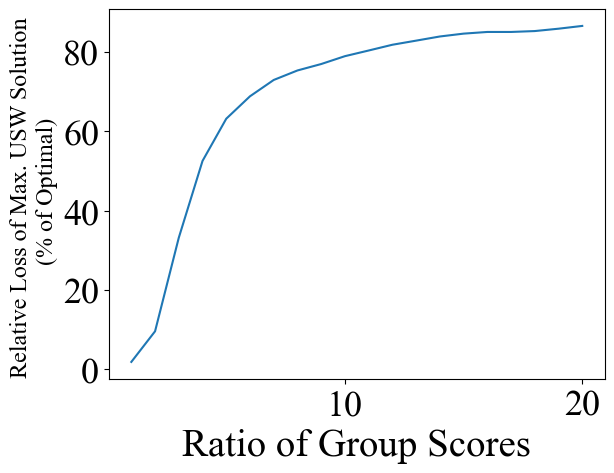

In [93]:
sns.lineplot(x=divisor_options, y=[100*x for x in varying_divisors])

fs = 26
plt.ylabel("Relative Loss of Max. USW Solution \n (% of Optimal)", fontsize=fs/1.5)
plt.xlabel("Ratio of Group Scores", fontsize=fs+2)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.savefig("../Plots/GESW_LOSS_DIVISOR.pdf", bbox_inches='tight')

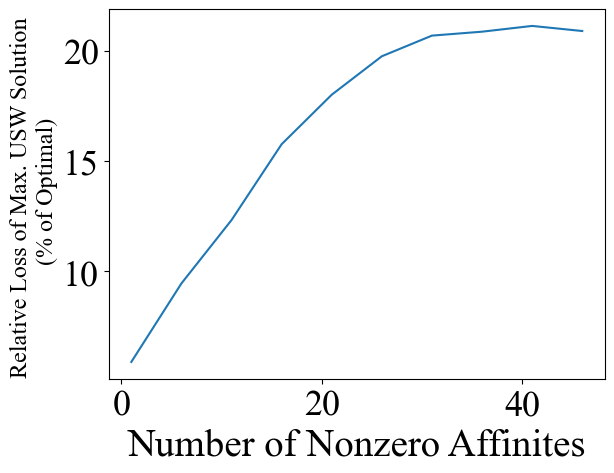

In [94]:
sns.lineplot(x=num_nonzero_options, y=[100*x for x in varying_num_nonzero])

fs = 26
plt.ylabel("Relative Loss of Max. USW Solution \n (% of Optimal)", fontsize=fs/1.5)
plt.xlabel("Number of Nonzero Affinites", fontsize=fs+2)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.savefig("../Plots/GESW_LOSS_NUMNONZERO.pdf", bbox_inches='tight')

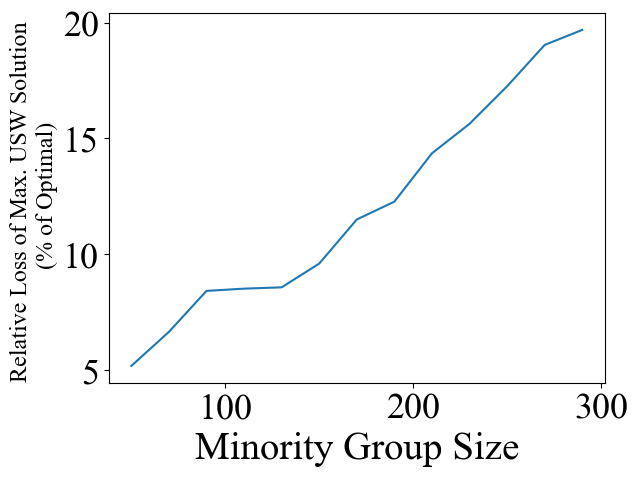

In [95]:
sns.lineplot(x=group_size_options[:len(varying_group_size)], y=[100*x for x in varying_group_size])

fs = 26
plt.ylabel("Relative Loss of Max. USW Solution \n (% of Optimal)", fontsize=fs/1.5)
plt.xlabel("Minority Group Size", fontsize=fs+2)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.savefig("../Plots/GESW_LOSS_GRPSIZE.pdf", bbox_inches='tight')

In [7]:
# Now the extra experiments, we're adding based on the comments from reviewer 5Awd.
# They want to know why CVaR is important, when USW and CVaR USW track the same in the plot.
# We're going to try skewing the variances so that the highest scores get higher variances.
# Because the max USW will still pick them but the CVaR USW will notice the higher variance and pick another.
# Also, we wanna try CVaR with alpha=0.2, 0.3, 0.4.

from copy import deepcopy
mod_mu = deepcopy(mu)
mod_zeta = deepcopy(z)

nrevs, npaps = mod_mu.shape
sample_frac = .2
gen = np.random.default_rng(seed=1)

chosen_revs = gen.choice(range(nrevs), int(sample_frac * nrevs))
chosen_paps = gen.choice(range(npaps), int(sample_frac * npaps))

mod_mu = mod_mu[chosen_revs, :][:, chosen_paps]
mod_zeta = mod_zeta[chosen_revs, :][:, chosen_paps]

dset_idx = 0
cs = [3, 2, 2]
ls = [15, 15, 10]
covs_lb = cs[dset_idx] * np.ones(mod_mu.shape[1])
covs_ub = covs_lb
loads = ls[dset_idx] * np.ones(mod_mu.shape[0])
coi_mask = np.ones_like(mod_mu)
groups = np.load("../data/AAMAS/groups_1.npy")

variance_multiplier = 2000
num_top_multiplied = 10

print(variance_multiplier, num_top_multiplied)

print(np.sort(mod_zeta, axis=0)[-4:, :])

for i in range(mod_mu.shape[1]):
    mod_zeta[np.argsort(mod_mu[:, i])[-1*num_top_multiplied:], i] *= variance_multiplier
    
print(np.sort(mod_zeta, axis=0)[-4:, :])

2000 10
[[0.01134921 0.15476407 0.08685577 0.03961458 0.09219092 0.08679941
  0.03507411 0.16214878 0.15476407 0.10020736 0.13390521 0.06172327
  0.10782121 0.1258505  0.10622384 0.05453223 0.06172327 0.02233191
  0.13361395 0.04431201 0.13954205 0.15282329 0.10782121 0.03507411
  0.04611226 0.18783203 0.1151207  0.09192736 0.05747171 0.01426998
  0.15444997 0.07133081 0.01192144 0.02854224 0.02935615 0.07546392
  0.07474355 0.10147621 0.23818546 0.08685577 0.02519752 0.10990536
  0.02926725 0.18768332 0.12682941 0.0609316  0.01115043 0.29033925
  0.15633141 0.01240893 0.12826275 0.06638278 0.10416207 0.13460907
  0.16214878 0.23768758 0.06202408 0.09617056 0.05703632 0.03633496
  0.0717888  0.04444514 0.02121601 0.14050703 0.09028641 0.01163598
  0.1202254  0.07213585 0.07195481 0.01163598 0.12199332 0.0137393
  0.11404247 0.24045987 0.15988956 0.14236894 0.01240893 0.12288824
  0.20420706 0.11392587 0.08759273 0.15938487 0.04882969 0.15168116
  0.0552831  0.15838065 0.30764352 0.0943

In [8]:
print(np.sort(mod_zeta, axis=0)[-4:, 20:40])

[[239.74487092 275.10286809 161.75962252  51.67216846  54.36872348
  324.52927753 175.3288566  108.554383    86.60613633  15.97821118
  264.32414801 116.87661092  12.13687038  27.85731352  31.81663384
   92.00522391 136.27488996 128.96383584 314.12977235 141.88079373]
 [240.47217497 288.174224   161.75962252  66.2733092   75.24379015
  343.16225555 185.4422584  151.63485594  98.00252216  16.61933219
  275.13373461 165.90818494  16.53378792  28.4420452   34.46684298
   97.37056695 136.27488996 137.7470302  338.83655282 145.65622758]
 [261.30521001 295.63178193 216.02621597  70.1482105   79.82883471
  343.16225555 185.4422584  183.85471178 114.94342905  16.64952091
  308.89994309 172.71561812  16.60644979  29.01591656  37.40883314
  151.22798173 145.67798929 156.20854158 344.02606748 229.4527919 ]
 [301.99912368 305.6465725  242.52782152 114.26227172 101.53455374
  375.66406059 273.5779918  231.11831417 114.94342905  17.5294118
  462.175688   177.27649406  23.84287417  40.2937654   92.52

In [9]:
# Sample, run CVaR and regular max USW
usw_alloc = solve_usw_gurobi(mod_mu, covs_lb, covs_ub, loads, coi_mask)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.04s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Curr

In [10]:
# samples = [gen.standard_cauchy(size=mod_mu.shape)*np.sqrt(mod_zeta) + mod_mu for _ in range(10)]

In [11]:
conf_level = .3

In [9]:
from compute_allocations import solve_cvar_usw_gauss, solve_cvar_usw, solve_adv_usw
# cvar_usw_alloc = solve_cvar_usw(covs_lb, covs_ub, loads, conf_level, samples, coi_mask)
# cvar_usw_alloc = solve_cvar_usw_gauss(mod_mu, mod_zeta, covs_lb, covs_ub, loads, conf_level, coi_mask)


In [56]:
from gurobipy import Model, multidict, GRB
from scipy.stats import norm

m = Model("TPMS")
mu_matrix = mod_mu
sigma_matrix = mod_zeta

alloc = m.addMVar(mu_matrix.shape, vtype=GRB.BINARY, name='alloc')

m.addConstr(alloc.sum(axis=0) >= covs_lb)
m.addConstr(alloc.sum(axis=0) <= covs_ub)
m.addConstr(alloc.sum(axis=1) <= loads)
m.addConstr(alloc <= coi_mask)

aux = m.addVar(lb=0)

# m.addConstr(aux ** 2 == (alloc * sigma_matrix * alloc).sum())

# frac = norm.pdf(norm.ppf(conf_level)) / (1 - conf_level)
# obj = (alloc * mu_matrix).sum() - frac * aux
# m.setObjective(obj, GRB.MAXIMIZE)

# m.setParam("NonConvex", 2)
m.setParam("NonConvex", 2)

m.addConstr(aux ** 2 == (alloc * sigma_matrix * alloc).sum())

frac = norm.pdf(norm.ppf(conf_level)) / (1 - conf_level)
obj = (alloc * mu_matrix).sum() - frac * aux
m.setObjective(obj, GRB.MAXIMIZE)
m.optimize()

cvar_usw_alloc = alloc.x

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4881 columns and 19520 nonzeros
Model fingerprint: 0xcbf4d3ab
Model has 1 quadratic constraint
Variable types: 1 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-03, 6e+02]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 5002 rows and 0 columns
Presolve time: 0.01s
Presolved: 165 rows, 4881 columns, 24402 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 1 continuous, 4880 integer (4880 binary)

Root relaxation: objective 2.497688e+02, 442 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds     

In [57]:
eval_samples = get_samples(mod_mu, mod_zeta, "gauss_aamas1", num_samples=10000)
# eval_samples = [gen.standard_cauchy(size=mod_mu.shape)*np.sqrt(mod_zeta) + mod_mu for _ in range(10)]

In [58]:
cvar_usw_on_cvar = compute_cvar_usw(cvar_usw_alloc, eval_samples, conf_level)

In [59]:
cvar_usw_on_usw = compute_cvar_usw(usw_alloc, eval_samples, conf_level)

In [60]:
# sns.histplot(eval_samples[0].flatten())

In [61]:
usws = []
for vs in eval_samples:
    usws.append(compute_usw(cvar_usw_alloc, vs))
cutoff = int(len(usws)*conf_level)
# print(sorted(usws))
# print()
# print(sorted(usws)[:cutoff])
print(np.mean(sorted(usws)[:cutoff]))

1.1298755965263698


In [62]:
usws = []
for vs in eval_samples:
    usws.append(compute_usw(usw_alloc, vs))
cutoff = int(len(usws)*conf_level)
# print(sorted(usws))
# print()
# print(sorted(usws)[:cutoff])
print(np.mean(sorted(usws)[:cutoff]))

0.5822647413170668


In [10]:
def run_single_experiment(variance_multiplier = 10, num_top_multiplied = 10, conf_level = 0.3):
    mod_mu = deepcopy(mu)
    mod_zeta = deepcopy(z)

    nrevs, npaps = mod_mu.shape
    sample_frac = .2
    gen = np.random.default_rng(seed=1)

    chosen_revs = gen.choice(range(nrevs), int(sample_frac * nrevs))
    chosen_paps = gen.choice(range(npaps), int(sample_frac * npaps))

    mod_mu = mod_mu[chosen_revs, :][:, chosen_paps]
    mod_zeta = mod_zeta[chosen_revs, :][:, chosen_paps]

    dset_idx = 0
    cs = [3, 2, 2]
    ls = [15, 15, 10]
    covs_lb = cs[dset_idx] * np.ones(mod_mu.shape[1])
    covs_ub = covs_lb
    loads = ls[dset_idx] * np.ones(mod_mu.shape[0])
    coi_mask = np.ones_like(mod_mu)
    groups = np.load("../data/AAMAS/groups_1.npy")

    for i in range(mod_mu.shape[1]):
        mod_zeta[np.argsort(mod_mu[:, i])[-1*num_top_multiplied:], i] *= variance_multiplier

        
    usw_alloc = solve_usw_gurobi(mod_mu, covs_lb, covs_ub, loads, coi_mask)
    
    m = Model("TPMS")
    mu_matrix = mod_mu
    sigma_matrix = mod_zeta

    alloc = m.addMVar(mu_matrix.shape, vtype=GRB.BINARY, name='alloc')

    m.addConstr(alloc.sum(axis=0) >= covs_lb)
    m.addConstr(alloc.sum(axis=0) <= covs_ub)
    m.addConstr(alloc.sum(axis=1) <= loads)
    m.addConstr(alloc <= coi_mask)

    aux = m.addVar(lb=0)

    # m.addConstr(aux ** 2 == (alloc * sigma_matrix * alloc).sum())

    # frac = norm.pdf(norm.ppf(conf_level)) / (1 - conf_level)
    # obj = (alloc * mu_matrix).sum() - frac * aux
    # m.setObjective(obj, GRB.MAXIMIZE)

    # m.setParam("NonConvex", 2)
    m.setParam("NonConvex", 2)

    m.addConstr(aux ** 2 == (alloc * sigma_matrix * alloc).sum())

    frac = norm.pdf(norm.ppf(conf_level)) / (1 - conf_level)
    obj = (alloc * mu_matrix).sum() - frac * aux
    m.setObjective(obj, GRB.MAXIMIZE)
    m.optimize()

    cvar_usw_alloc = alloc.x
    
    eval_samples = get_samples(mod_mu, mod_zeta, "gauss_aamas1", num_samples=10000)

    usws = []
    for vs in eval_samples:
        usws.append(compute_usw(cvar_usw_alloc, vs))
    cutoff = int(len(usws)*conf_level)
    cvar_on_cvar = np.mean(sorted(usws)[:cutoff])
    
    usws = []
    for vs in eval_samples:
        usws.append(compute_usw(usw_alloc, vs))
    cutoff = int(len(usws)*conf_level)
    cvar_on_usw = np.mean(sorted(usws)[:cutoff])
    
    print(cvar_on_cvar, cvar_on_usw)
    
    return (cvar_on_cvar - cvar_on_usw)*100/cvar_on_cvar

In [67]:
run_single_experiment()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.03s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

0.2873041662689866

In [82]:
vm_opts = np.arange(1, 500, 20)
vm_out = []
for vm in tqdm(vm_opts):
    vm_out.append(run_single_experiment(variance_multiplier = vm, num_top_multiplied=3))
    print(vm_out)

  0%|          | 0/25 [00:00<?, ?it/s]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.01s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

  RHS range        [1e+00, 2e+01]
Presolve removed 5002 rows and 0 columns
Presolve time: 0.01s
Presolved: 165 rows, 4881 columns, 24402 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 1 continuous, 4880 integer (4880 binary)

Root relaxation: objective 2.756940e+02, 439 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  275.69396    0    1          -  275.69396      -     -    0s
H    0     0                     271.7217475  275.69396  1.46%     -    0s
H    0     0                     271.7255505  275.69396  1.46%     -    0s

Cutting planes:
  RLT: 1

Explored 1 nodes (439 simplex iterations) in 0.74 seconds (0.38 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 271.726 271.722 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.717255504968e+02, best bound 2.7172555


Root relaxation: objective 2.815399e+02, 453 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     281.5398875  281.53989  0.00%     -    0s

Explored 1 nodes (453 simplex iterations) in 0.05 seconds (0.03 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 281.54 155.774 113.741 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.815398874590e+02, best bound 2.815398874590e+02, gap 0.0000%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4881 columns and 19520 nonzeros
Model fingerprint: 0x232e3293
Model has 1 quadratic constraint
Variable t

H    0     0                     264.1181500  270.94190  2.58%     -    0s

Cutting planes:
  RLT: 1

Explored 1 nodes (444 simplex iterations) in 0.79 seconds (0.38 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 264.118 264.097 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.641181500465e+02, best bound 2.641181500465e+02, gap 0.0000%
1.9906404191321405 1.9330798786686374
[0.07947926860306775, 0.4751376195564547, 0.8594710231406458, 1.2001124549093334, 1.6133870048419647, 1.9916904291617088, 2.446799555097799, 2.8915589129149595]
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [


Explored 1 nodes (453 simplex iterations) in 0.05 seconds (0.03 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 281.54 155.774 113.741 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.815398874590e+02, best bound 2.815398874590e+02, gap 0.0000%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4881 columns and 19520 nonzeros
Model fingerprint: 0x46383e7a
Model has 1 quadratic constraint
Variable types: 1 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-03, 6e+01]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 5002 rows and 0 columns
Presolve time: 0.02s
Presolved: 16


Cutting planes:
  RLT: 1

Explored 1 nodes (449 simplex iterations) in 0.75 seconds (0.38 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 259.412 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.594117753967e+02, best bound 2.594240760824e+02, gap 0.0047%
1.9157596718967125 1.8185056958597603
[0.07947926860306775, 0.4751376195564547, 0.8594710231406458, 1.2001124549093334, 1.6133870048419647, 1.9916904291617088, 2.446799555097799, 2.8915589129149595, 3.164413100591276, 3.6080752535747287, 3.9565297874067986, 4.456587289612869, 5.076522773896015]
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matr

Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     281.5398875  281.53989  0.00%     -    0s

Explored 1 nodes (453 simplex iterations) in 0.05 seconds (0.03 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 281.54 155.774 113.741 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.815398874590e+02, best bound 2.815398874590e+02, gap 0.0000%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4881 columns and 19520 nonzeros
Model fingerprint: 0x9b6c

Variable types: 1 continuous, 4880 integer (4880 binary)

Root relaxation: objective 2.664253e+02, 441 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  266.42529    0    1          -  266.42529      -     -    0s
H    0     0                     255.8652239  266.42529  4.13%     -    0s

Cutting planes:
  RLT: 1

Explored 1 nodes (441 simplex iterations) in 0.76 seconds (0.38 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 255.865 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.558652238947e+02, best bound 2.558739116931e+02, gap 0.0034%
1.8568687956372967 1.726082732973717
[0.07947926860306775, 0.4751376195564547, 0.8594710231406458, 1.2001124549093334, 1.6133870048419647, 1.9916904291617088, 2.446799555097799, 2.8915589129149595, 3.164413100591276, 3.6080752535747287, 3.956529787406

Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.02s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     281.5398875  281.53989  0.00%     -    0s

Explored 1 nodes (453 simplex iterations) in 0.06 seconds (0.03 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 281.54 155.774 113.741 

Optim

Model fingerprint: 0x8607c7f0
Model has 1 quadratic constraint
Variable types: 1 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-03, 1e+02]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 5002 rows and 0 columns
Presolve time: 0.01s
Presolved: 165 rows, 4881 columns, 24402 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 1 continuous, 4880 integer (4880 binary)

Root relaxation: objective 2.649436e+02, 467 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  264.94357    0    1          -  264.94357      -     -    0s
H    0     0                     252.9734393  264.94357  4.73%     -    0s

Cutting planes:
  RLT: 1

Explored 1 nodes (467 simplex iterations) in 0.75 seco

In [86]:
num_top_opts = np.arange(1, 15, 1)
nt_out = []
for nt in tqdm(num_top_opts):
    nt_out.append(run_single_experiment(num_top_multiplied = nt, variance_multiplier=200))
    print(nt_out)

  0%|          | 0/14 [00:00<?, ?it/s]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.02s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

  RHS range        [1e+00, 2e+01]
Presolve removed 5002 rows and 0 columns
Presolve time: 0.01s
Presolved: 165 rows, 4881 columns, 24402 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 1 continuous, 4880 integer (4880 binary)

Root relaxation: objective 2.692658e+02, 443 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  269.26582    0    1          -  269.26582      -     -    0s
H    0     0                     261.1465811  269.26582  3.11%     -    0s
H    0     0                     261.1594842  269.26582  3.10%     -    0s

Cutting planes:
  RLT: 1

Explored 1 nodes (443 simplex iterations) in 0.70 seconds (0.38 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 261.159 261.147 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.611594841539e+02, best bound 2.6116007


Root relaxation: objective 2.815399e+02, 453 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     281.5398875  281.53989  0.00%     -    0s

Explored 1 nodes (453 simplex iterations) in 0.04 seconds (0.03 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 281.54 155.774 113.741 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.815398874590e+02, best bound 2.815398874590e+02, gap 0.0000%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4881 columns and 19520 nonzeros
Model fingerprint: 0x0613a112
Model has 1 quadratic constraint
Variable t

Thread count was 8 (of 8 available processors)

Solution count 2: 255.8 255.796 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.557999222433e+02, best bound 2.557999222433e+02, gap 0.0000%
1.8312551146209268 1.767858482372574
[4.108045510679845, 3.9545164720036365, 3.9425936489615205, 4.145691808683275, 3.8815259621957616, 3.870207564969669, 3.462769019105182, 3.4619224673934093]
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002

Best objective 2.815398874590e+02, best bound 2.815398874590e+02, gap 0.0000%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4881 columns and 19520 nonzeros
Model fingerprint: 0x3b7228b4
Model has 1 quadratic constraint
Variable types: 1 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-03, 6e+01]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 5002 rows and 0 columns
Presolve time: 0.02s
Presolved: 165 rows, 4881 columns, 24402 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 1 continuous, 4880 integer (4880 binary)

Root relaxation: objective 2.699564e+02, 432 iterations, 0.02 seconds (0

Best objective 2.550822238609e+02, best bound 2.550822239774e+02, gap 0.0000%
1.8145712731937595 1.758525527836205
[4.108045510679845, 3.9545164720036365, 3.9425936489615205, 4.145691808683275, 3.8815259621957616, 3.870207564969669, 3.462769019105182, 3.4619224673934093, 3.541170329628013, 3.3399734577042612, 3.3185101105440684, 3.1206358672271306, 3.088649433918924]
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve

<Axes: >

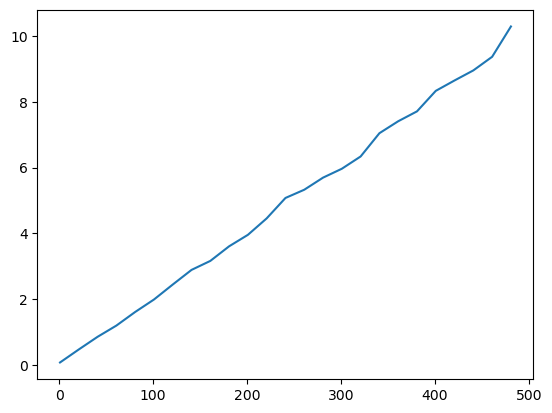

In [87]:
sns.lineplot(x=vm_opts, y=vm_out)

<Axes: >

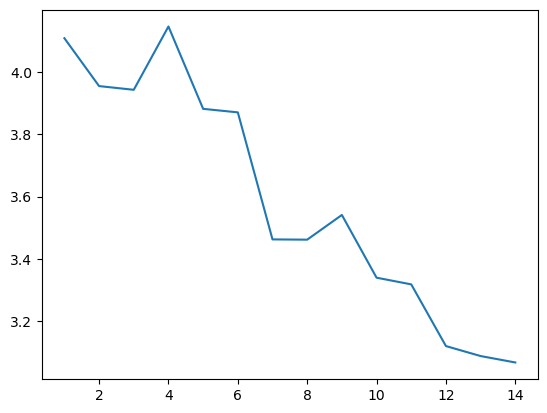

In [88]:
sns.lineplot(x=num_top_opts, y=nt_out)

In [11]:
from scipy.stats import skewnorm, skewcauchy
# r = skewnorm.rvs(-10, size=mod_mu.shape)*np.sqrt(mod_zeta) + mod_mu
r = skewcauchy.rvs(-.1, size=mod_mu.shape)*np.sqrt(mod_zeta) + mod_mu
print(mod_mu, "\n", mod_zeta)
print(r)
print(r.shape)
import matplotlib.pyplot as plt
plt.clf()
sns.histplot(r.flatten())

[[0.01       0.59470925 0.36596989 ... 0.69156685 0.15272712 0.60011168]
 [0.54086642 0.19886354 0.44518996 ... 0.12480354 0.01       0.24790075]
 [0.58104933 0.55210951 0.01       ... 0.45739387 0.01       0.54180139]
 ...
 [0.08242006 0.17785609 0.46959969 ... 0.3599728  0.01       0.74667887]
 [0.19763095 0.22404433 0.38598164 ... 0.06494673 0.30464366 0.41968285]
 [0.46845149 0.11435045 0.01       ... 0.19939669 0.01       0.01      ]] 
 [[8.93445501e-03 1.96977869e+02 6.71502140e-02 ... 2.65400497e+02
  1.05785430e+02 3.41552065e+02]
 [1.92042187e+01 1.12691862e-01 1.13481956e+02 ... 1.32520481e-01
  2.46709556e-02 9.10347022e-02]
 [2.19802986e+01 2.27287171e+02 8.68557677e-02 ... 2.07435574e+02
  2.97956558e-02 3.32300187e+02]
 ...
 [1.09677206e-02 1.54764075e-01 2.40230372e+02 ... 1.21925182e-01
  3.66221345e-02 1.90214589e+02]
 [1.28187969e-02 1.68537217e-01 6.75727667e-02 ... 1.24090287e-01
  1.28581606e+02 1.26562904e-01]
 [1.16440446e-02 1.66588838e-01 4.91797334e-02 ... 1.4

<Axes: ylabel='Count'>

Error in callback <function flush_figures at 0x000002B41E99EC10> (for post_execute):


KeyboardInterrupt: 

In [12]:
from scipy.stats import skewnorm, skewcauchy

def get_samples_cauchy(mod_mu, mod_zeta, nsamples):
    gen = np.random.default_rng(seed=1)
    return [gen.standard_cauchy(size=mod_mu.shape)*np.sqrt(mod_zeta) + mod_mu for _ in range(nsamples)]

def get_samples_skewnorm(mod_mu, mod_zeta, nsamples, skew):
    return [skewnorm.rvs(skew, size=mod_mu.shape)*np.sqrt(mod_zeta) + mod_mu for _ in range(nsamples)]

def get_samples_skewcauchy(mod_mu, mod_zeta, nsamples, skew):
    return [skewcauchy.rvs(skew, size=mod_mu.shape)*np.sqrt(mod_zeta) + mod_mu for _ in range(nsamples)]


In [17]:
# Now try with skewed Cauchy
def run_single_experiment_varying_sampler(variance_multiplier = 10, num_top_multiplied = 10, conf_level = 0.3, sample_fn = get_samples_cauchy, skew=1):
    mod_mu = deepcopy(mu)
    mod_zeta = deepcopy(z)

    nrevs, npaps = mod_mu.shape
    sample_frac = .2
    gen = np.random.default_rng(seed=1)

    chosen_revs = gen.choice(range(nrevs), int(sample_frac * nrevs))
    chosen_paps = gen.choice(range(npaps), int(sample_frac * npaps))

    mod_mu = mod_mu[chosen_revs, :][:, chosen_paps]
    mod_zeta = mod_zeta[chosen_revs, :][:, chosen_paps]

    dset_idx = 0
    cs = [3, 2, 2]
    ls = [15, 15, 10]
    covs_lb = cs[dset_idx] * np.ones(mod_mu.shape[1])
    covs_ub = covs_lb
    loads = ls[dset_idx] * np.ones(mod_mu.shape[0])
    coi_mask = np.ones_like(mod_mu, dtype=np.int32)
    groups = np.load("../data/AAMAS/groups_1.npy")
    groups = np.zeros_like(covs_lb, dtype=np.int32)

    for i in range(mod_mu.shape[1]):
        mod_zeta[np.argsort(mod_mu[:, i])[-1*num_top_multiplied:], i] *= variance_multiplier

        
    usw_alloc = solve_usw_gurobi(mod_mu, covs_lb, covs_ub, loads, coi_mask)
    
    nsamples = 100
    samples = sample_fn(mod_mu, mod_zeta, nsamples, skew)
    cvar_usw_alloc = solve_cvar_usw(covs_lb, covs_ub, loads, conf_level, samples, coi_mask)
    from scipy.stats import chi2
    rhs = np.sqrt(chi2.ppf(1-conf_level, df=np.sum(coi_mask)))
    robust_usw_alloc, _, _ = solve_adv_usw(mod_mu, mod_zeta, covs_lb, covs_ub, loads, [rhs], coi_mask, groups,
                  method="IQP")
    
    
    eval_samples = sample_fn(mod_mu, mod_zeta, 10000, skew)

    usws = []
    for vs in eval_samples:
        usws.append(compute_usw(cvar_usw_alloc, vs))
    cutoff = int(len(usws)*conf_level)
    cvar_on_cvar = np.mean(sorted(usws)[:cutoff])
    
    usws = []
    for vs in eval_samples:
        usws.append(compute_usw(usw_alloc, vs))
    cutoff = int(len(usws)*conf_level)
    cvar_on_usw = np.mean(sorted(usws)[:cutoff])
    
    usws = []
    for vs in eval_samples:
        usws.append(compute_usw(robust_usw_alloc, vs))
    cutoff = int(len(usws)*conf_level)
    cvar_on_robust = np.mean(sorted(usws)[:cutoff])
    
    print(cvar_on_cvar, cvar_on_usw, cvar_on_robust)
    
    return (cvar_on_cvar - cvar_on_usw)*100/cvar_on_cvar

In [18]:
run_single_experiment_varying_sampler(sample_fn=get_samples_skewnorm, skew=-0.5)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.01s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xe8ba68ee
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 3936 columns
Presolve time: 0.01s
Presolved: 946 rows, 946 columns, 1891 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.470e+05
 Factor NZ  : 4.479e+05 (roughly 4 MB of memory)
 Factor Ops : 2.826e+08 (less than 1 second per iteration)
 Threads    : 4

                  Objective                R

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x330fb570
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 2552 columns
Presolve time: 0.01s
Presolved: 2330 rows, 2330 columns, 4659 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.659e+03
 Factor NZ  : 7.396e+03 (roughly 2 MB of memory)
 Factor Ops : 3.112e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x36508b41
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 931 columns
Presolve time: 0.01s
Presolved: 3951 rows, 3951 columns, 7901 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.901e+03
 Factor NZ  : 1.226e+04 (roughly 3 MB of memory)
 Factor Ops : 4.571e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9b97c776
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1477 columns
Presolve time: 0.01s
Presolved: 3405 rows, 3405 columns, 6809 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.809e+03
 Factor NZ  : 1.062e+04 (roughly 3 MB of memory)
 Factor Ops : 4.079e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x39ce5103
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [9e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1283 columns
Presolve time: 0.01s
Presolved: 3599 rows, 3599 columns, 7197 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.197e+03
 Factor NZ  : 1.120e+04 (roughly 3 MB of memory)
 Factor Ops : 4.254e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xbec97180
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1154 columns
Presolve time: 0.01s
Presolved: 3728 rows, 3728 columns, 7455 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.455e+03
 Factor NZ  : 1.159e+04 (roughly 3 MB of memory)
 Factor Ops : 4.370e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xf47460df
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1096 columns
Presolve time: 0.01s
Presolved: 3786 rows, 3786 columns, 7571 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.571e+03
 Factor NZ  : 1.176e+04 (roughly 3 MB of memory)
 Factor Ops : 4.422e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x15d9c1c6
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1116 columns
Presolve time: 0.01s
Presolved: 3766 rows, 3766 columns, 7531 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.531e+03
 Factor NZ  : 1.170e+04 (roughly 3 MB of memory)
 Factor Ops : 4.404e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3f9c5e93
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1138 columns
Presolve time: 0.01s
Presolved: 3744 rows, 3744 columns, 7487 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.487e+03
 Factor NZ  : 1.164e+04 (roughly 3 MB of memory)
 Factor Ops : 4.384e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x54b6c8f2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [6e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1109 columns
Presolve time: 0.01s
Presolved: 3773 rows, 3773 columns, 7545 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.545e+03
 Factor NZ  : 1.173e+04 (roughly 3 MB of memory)
 Factor Ops : 4.410e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xc183567b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1093 columns
Presolve time: 0.01s
Presolved: 3789 rows, 3789 columns, 7577 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.577e+03
 Factor NZ  : 1.177e+04 (roughly 3 MB of memory)
 Factor Ops : 4.425e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x48e1defc
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1068 columns
Presolve time: 0.01s
Presolved: 3814 rows, 3814 columns, 7627 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.627e+03
 Factor NZ  : 1.185e+04 (roughly 3 MB of memory)
 Factor Ops : 4.447e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xa2647758
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 458 columns
Presolve time: 0.01s
Presolved: 4424 rows, 4424 columns, 8847 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 8.847e+03
 Factor NZ  : 1.368e+04 (roughly 4 MB of memory)
 Factor Ops : 4.996e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x5263e8b0
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 370 columns
Presolve time: 0.01s
Presolved: 4512 rows, 4512 columns, 9023 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.023e+03
 Factor NZ  : 1.394e+04 (roughly 4 MB of memory)
 Factor Ops : 5.075e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x40b8bb3b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.01s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x8e900ae2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.01s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x34ea7df3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x64942f67
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x2d3e55b5
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3c7ddf24
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x1af7ad3c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9dc5b1e4
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x75cf4abb
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x6207eb4b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x79d99adf
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x596db26c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x25804354
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb5121085
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd6f84b68
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x4f86661a
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x377f77be
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x49c7c5a1
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb4b77a97
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x892c3808
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd86c3cc3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

4.792571953998702

In [19]:
run_single_experiment_varying_sampler(sample_fn=get_samples_skewnorm, skew=-1)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.01s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xe8ba68ee
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 3936 columns
Presolve time: 0.01s
Presolved: 946 rows, 946 columns, 1891 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.470e+05
 Factor NZ  : 4.479e+05 (roughly 4 MB of memory)
 Factor Ops : 2.826e+08 (less than 1 second per iteration)
 Threads    : 4

                  Objective                R


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x330fb570
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 2552 columns
Presolve time: 0.01s
Presolved: 2330 rows, 2330 columns, 4659 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.659e+03
 Factor NZ  : 7.396e+03 (roughly 2 MB of memory)
 Factor Ops : 3.112e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x36508b41
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 931 columns
Presolve time: 0.01s
Presolved: 3951 rows, 3951 columns, 7901 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.901e+03
 Factor NZ  : 1.226e+04 (roughly 3 MB of memory)
 Factor Ops : 4.571e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9b97c776
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1477 columns
Presolve time: 0.01s
Presolved: 3405 rows, 3405 columns, 6809 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.809e+03
 Factor NZ  : 1.062e+04 (roughly 3 MB of memory)
 Factor Ops : 4.079e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x39ce5103
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [9e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1283 columns
Presolve time: 0.01s
Presolved: 3599 rows, 3599 columns, 7197 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.197e+03
 Factor NZ  : 1.120e+04 (roughly 3 MB of memory)
 Factor Ops : 4.254e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xbec97180
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1154 columns
Presolve time: 0.01s
Presolved: 3728 rows, 3728 columns, 7455 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.455e+03
 Factor NZ  : 1.159e+04 (roughly 3 MB of memory)
 Factor Ops : 4.370e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xf47460df
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1096 columns
Presolve time: 0.00s
Presolved: 3786 rows, 3786 columns, 7571 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.571e+03
 Factor NZ  : 1.176e+04 (roughly 3 MB of memory)
 Factor Ops : 4.422e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x15d9c1c6
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1116 columns
Presolve time: 0.01s
Presolved: 3766 rows, 3766 columns, 7531 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.531e+03
 Factor NZ  : 1.170e+04 (roughly 3 MB of memory)
 Factor Ops : 4.404e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3f9c5e93
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1138 columns
Presolve time: 0.01s
Presolved: 3744 rows, 3744 columns, 7487 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.487e+03
 Factor NZ  : 1.164e+04 (roughly 3 MB of memory)
 Factor Ops : 4.384e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x54b6c8f2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [6e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1109 columns
Presolve time: 0.01s
Presolved: 3773 rows, 3773 columns, 7545 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.545e+03
 Factor NZ  : 1.173e+04 (roughly 3 MB of memory)
 Factor Ops : 4.410e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xc183567b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1093 columns
Presolve time: 0.01s
Presolved: 3789 rows, 3789 columns, 7577 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.577e+03
 Factor NZ  : 1.177e+04 (roughly 3 MB of memory)
 Factor Ops : 4.425e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x48e1defc
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1068 columns
Presolve time: 0.01s
Presolved: 3814 rows, 3814 columns, 7627 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.627e+03
 Factor NZ  : 1.185e+04 (roughly 3 MB of memory)
 Factor Ops : 4.447e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xa2647758
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 458 columns
Presolve time: 0.01s
Presolved: 4424 rows, 4424 columns, 8847 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 8.847e+03
 Factor NZ  : 1.368e+04 (roughly 4 MB of memory)
 Factor Ops : 4.996e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x5263e8b0
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 370 columns
Presolve time: 0.01s
Presolved: 4512 rows, 4512 columns, 9023 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.023e+03
 Factor NZ  : 1.394e+04 (roughly 4 MB of memory)
 Factor Ops : 5.075e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x40b8bb3b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.01s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x8e900ae2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.01s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x34ea7df3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x64942f67
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x2d3e55b5
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3c7ddf24
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x1af7ad3c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9dc5b1e4
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x75cf4abb
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x6207eb4b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x79d99adf
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x596db26c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x25804354
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb5121085
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd6f84b68
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.01s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x4f86661a
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.02s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x377f77be
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.01s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x49c7c5a1
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb4b77a97
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x892c3808
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd86c3cc3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

16.48878479285701

In [20]:
run_single_experiment_varying_sampler(sample_fn=get_samples_skewnorm, skew=-2)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.02s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xe8ba68ee
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 3936 columns
Presolve time: 0.01s
Presolved: 946 rows, 946 columns, 1891 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.470e+05
 Factor NZ  : 4.479e+05 (roughly 4 MB of memory)
 Factor Ops : 2.826e+08 (less than 1 second per iteration)
 Threads    : 4

                  Objective                R


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x330fb570
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 2552 columns
Presolve time: 0.01s
Presolved: 2330 rows, 2330 columns, 4659 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.659e+03
 Factor NZ  : 7.396e+03 (roughly 2 MB of memory)
 Factor Ops : 3.112e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x36508b41
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 931 columns
Presolve time: 0.01s
Presolved: 3951 rows, 3951 columns, 7901 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.901e+03
 Factor NZ  : 1.226e+04 (roughly 3 MB of memory)
 Factor Ops : 4.571e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9b97c776
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1477 columns
Presolve time: 0.01s
Presolved: 3405 rows, 3405 columns, 6809 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.809e+03
 Factor NZ  : 1.062e+04 (roughly 3 MB of memory)
 Factor Ops : 4.079e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x39ce5103
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [9e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1283 columns
Presolve time: 0.01s
Presolved: 3599 rows, 3599 columns, 7197 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.197e+03
 Factor NZ  : 1.120e+04 (roughly 3 MB of memory)
 Factor Ops : 4.254e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xbec97180
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1154 columns
Presolve time: 0.01s
Presolved: 3728 rows, 3728 columns, 7455 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.455e+03
 Factor NZ  : 1.159e+04 (roughly 3 MB of memory)
 Factor Ops : 4.370e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xf47460df
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1096 columns
Presolve time: 0.01s
Presolved: 3786 rows, 3786 columns, 7571 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.571e+03
 Factor NZ  : 1.176e+04 (roughly 3 MB of memory)
 Factor Ops : 4.422e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x15d9c1c6
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1116 columns
Presolve time: 0.01s
Presolved: 3766 rows, 3766 columns, 7531 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.531e+03
 Factor NZ  : 1.170e+04 (roughly 3 MB of memory)
 Factor Ops : 4.404e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3f9c5e93
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1138 columns
Presolve time: 0.01s
Presolved: 3744 rows, 3744 columns, 7487 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.487e+03
 Factor NZ  : 1.164e+04 (roughly 3 MB of memory)
 Factor Ops : 4.384e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x54b6c8f2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [6e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1109 columns
Presolve time: 0.01s
Presolved: 3773 rows, 3773 columns, 7545 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.545e+03
 Factor NZ  : 1.173e+04 (roughly 3 MB of memory)
 Factor Ops : 4.410e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xc183567b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1093 columns
Presolve time: 0.01s
Presolved: 3789 rows, 3789 columns, 7577 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.577e+03
 Factor NZ  : 1.177e+04 (roughly 3 MB of memory)
 Factor Ops : 4.425e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

got lambda [0.00909423]
[70.2233555201845]
setting up group  0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x48e1defc
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1068 columns
Presolve time: 0.01s
Presolved: 3814 rows, 3814 columns, 7627 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.627e+03
 Factor NZ  : 1.185e+04 (roughly 3 MB of memory)
 Factor Ops : 4.447e+04 (less than 1 se


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xa2647758
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 458 columns
Presolve time: 0.01s
Presolved: 4424 rows, 4424 columns, 8847 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 8.847e+03
 Factor NZ  : 1.368e+04 (roughly 4 MB of memory)
 Factor Ops : 4.996e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x5263e8b0
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 370 columns
Presolve time: 0.01s
Presolved: 4512 rows, 4512 columns, 9023 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.023e+03
 Factor NZ  : 1.394e+04 (roughly 4 MB of memory)
 Factor Ops : 5.075e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x40b8bb3b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.01s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x8e900ae2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.01s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x34ea7df3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x64942f67
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x2d3e55b5
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3c7ddf24
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x1af7ad3c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9dc5b1e4
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x75cf4abb
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x6207eb4b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x79d99adf
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x596db26c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.03s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x25804354
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb5121085
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd6f84b68
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x4f86661a
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x377f77be
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x49c7c5a1
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

got lambda [0.00908922]
[70.2233555201845]
setting up group  0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb4b77a97
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 sec

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x892c3808
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd86c3cc3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

28.28771525652715

In [21]:
run_single_experiment_varying_sampler(sample_fn=get_samples_skewnorm, skew=-5)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.02s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xe8ba68ee
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 3936 columns
Presolve time: 0.01s
Presolved: 946 rows, 946 columns, 1891 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.470e+05
 Factor NZ  : 4.479e+05 (roughly 4 MB of memory)
 Factor Ops : 2.826e+08 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal   


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x330fb570
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 2552 columns
Presolve time: 0.01s
Presolved: 2330 rows, 2330 columns, 4659 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.659e+03
 Factor NZ  : 7.396e+03 (roughly 2 MB of memory)
 Factor Ops : 3.112e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x36508b41
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 931 columns
Presolve time: 0.01s
Presolved: 3951 rows, 3951 columns, 7901 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.901e+03
 Factor NZ  : 1.226e+04 (roughly 3 MB of memory)
 Factor Ops : 4.571e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9b97c776
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1477 columns
Presolve time: 0.01s
Presolved: 3405 rows, 3405 columns, 6809 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.809e+03
 Factor NZ  : 1.062e+04 (roughly 3 MB of memory)
 Factor Ops : 4.079e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x39ce5103
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [9e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1283 columns
Presolve time: 0.01s
Presolved: 3599 rows, 3599 columns, 7197 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.197e+03
 Factor NZ  : 1.120e+04 (roughly 3 MB of memory)
 Factor Ops : 4.254e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xbec97180
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1154 columns
Presolve time: 0.01s
Presolved: 3728 rows, 3728 columns, 7455 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.455e+03
 Factor NZ  : 1.159e+04 (roughly 3 MB of memory)
 Factor Ops : 4.370e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xf47460df
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1096 columns
Presolve time: 0.01s
Presolved: 3786 rows, 3786 columns, 7571 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.571e+03
 Factor NZ  : 1.176e+04 (roughly 3 MB of memory)
 Factor Ops : 4.422e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x15d9c1c6
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1116 columns
Presolve time: 0.01s
Presolved: 3766 rows, 3766 columns, 7531 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.531e+03
 Factor NZ  : 1.170e+04 (roughly 3 MB of memory)
 Factor Ops : 4.404e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3f9c5e93
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1138 columns
Presolve time: 0.00s
Presolved: 3744 rows, 3744 columns, 7487 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.487e+03
 Factor NZ  : 1.164e+04 (roughly 3 MB of memory)
 Factor Ops : 4.384e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x54b6c8f2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [6e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1109 columns
Presolve time: 0.01s
Presolved: 3773 rows, 3773 columns, 7545 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.545e+03
 Factor NZ  : 1.173e+04 (roughly 3 MB of memory)
 Factor Ops : 4.410e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xc183567b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1093 columns
Presolve time: 0.01s
Presolved: 3789 rows, 3789 columns, 7577 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.577e+03
 Factor NZ  : 1.177e+04 (roughly 3 MB of memory)
 Factor Ops : 4.425e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x48e1defc
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1068 columns
Presolve time: 0.01s
Presolved: 3814 rows, 3814 columns, 7627 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.627e+03
 Factor NZ  : 1.185e+04 (roughly 3 MB of memory)
 Factor Ops : 4.447e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xa2647758
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 458 columns
Presolve time: 0.01s
Presolved: 4424 rows, 4424 columns, 8847 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 8.847e+03
 Factor NZ  : 1.368e+04 (roughly 4 MB of memory)
 Factor Ops : 4.996e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x5263e8b0
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 370 columns
Presolve time: 0.01s
Presolved: 4512 rows, 4512 columns, 9023 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.023e+03
 Factor NZ  : 1.394e+04 (roughly 4 MB of memory)
 Factor Ops : 5.075e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x40b8bb3b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.01s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x8e900ae2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.02s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x34ea7df3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x64942f67
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x2d3e55b5
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3c7ddf24
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x1af7ad3c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9dc5b1e4
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x75cf4abb
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x6207eb4b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x79d99adf
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x596db26c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x25804354
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb5121085
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd6f84b68
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.03s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x4f86661a
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x377f77be
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x49c7c5a1
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb4b77a97
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x892c3808
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd86c3cc3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

34.51983841058078

In [22]:
run_single_experiment_varying_sampler(sample_fn=get_samples_skewnorm, skew=-10)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5164 rows, 4880 columns and 19520 nonzeros
Model fingerprint: 0x7e21189c
Variable types: 0 continuous, 4880 integer (4880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 113.7406734
Presolve removed 5002 rows and 0 columns
Presolve time: 0.03s
Presolved: 162 rows, 4880 columns, 9760 nonzeros
Variable types: 0 continuous, 4880 integer (4880 binary)
Found heuristic solution: objective 155.7737604

Root relaxation: objective 2.815399e+02, 453 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xe8ba68ee
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 3936 columns
Presolve time: 0.02s
Presolved: 946 rows, 946 columns, 1891 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.470e+05
 Factor NZ  : 4.479e+05 (roughly 4 MB of memory)
 Factor Ops : 2.826e+08 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal   


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x330fb570
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 2552 columns
Presolve time: 0.02s
Presolved: 2330 rows, 2330 columns, 4659 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.659e+03
 Factor NZ  : 7.396e+03 (roughly 2 MB of memory)
 Factor Ops : 3.112e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x36508b41
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 931 columns
Presolve time: 0.01s
Presolved: 3951 rows, 3951 columns, 7901 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.901e+03
 Factor NZ  : 1.226e+04 (roughly 3 MB of memory)
 Factor Ops : 4.571e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9b97c776
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1477 columns
Presolve time: 0.01s
Presolved: 3405 rows, 3405 columns, 6809 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.809e+03
 Factor NZ  : 1.062e+04 (roughly 3 MB of memory)
 Factor Ops : 4.079e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x39ce5103
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [9e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1283 columns
Presolve time: 0.02s
Presolved: 3599 rows, 3599 columns, 7197 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.197e+03
 Factor NZ  : 1.120e+04 (roughly 3 MB of memory)
 Factor Ops : 4.254e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xbec97180
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1154 columns
Presolve time: 0.02s
Presolved: 3728 rows, 3728 columns, 7455 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.455e+03
 Factor NZ  : 1.159e+04 (roughly 3 MB of memory)
 Factor Ops : 4.370e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xf47460df
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1096 columns
Presolve time: 0.01s
Presolved: 3786 rows, 3786 columns, 7571 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.571e+03
 Factor NZ  : 1.176e+04 (roughly 3 MB of memory)
 Factor Ops : 4.422e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x15d9c1c6
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1116 columns
Presolve time: 0.00s
Presolved: 3766 rows, 3766 columns, 7531 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.531e+03
 Factor NZ  : 1.170e+04 (roughly 3 MB of memory)
 Factor Ops : 4.404e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3f9c5e93
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1138 columns
Presolve time: 0.00s
Presolved: 3744 rows, 3744 columns, 7487 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.487e+03
 Factor NZ  : 1.164e+04 (roughly 3 MB of memory)
 Factor Ops : 4.384e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x54b6c8f2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [6e-13, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1109 columns
Presolve time: 0.02s
Presolved: 3773 rows, 3773 columns, 7545 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.545e+03
 Factor NZ  : 1.173e+04 (roughly 3 MB of memory)
 Factor Ops : 4.410e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xc183567b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [1e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1093 columns
Presolve time: 0.01s
Presolved: 3789 rows, 3789 columns, 7577 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.577e+03
 Factor NZ  : 1.177e+04 (roughly 3 MB of memory)
 Factor Ops : 4.425e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x48e1defc
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [2e-12, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 1068 columns
Presolve time: 0.02s
Presolved: 3814 rows, 3814 columns, 7627 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.627e+03
 Factor NZ  : 1.185e+04 (roughly 3 MB of memory)
 Factor Ops : 4.447e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xa2647758
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [3e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 458 columns
Presolve time: 0.00s
Presolved: 4424 rows, 4424 columns, 8847 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 8.847e+03
 Factor NZ  : 1.368e+04 (roughly 4 MB of memory)
 Factor Ops : 4.996e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x5263e8b0
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 370 columns
Presolve time: 0.01s
Presolved: 4512 rows, 4512 columns, 9023 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.023e+03
 Factor NZ  : 1.394e+04 (roughly 4 MB of memory)
 Factor Ops : 5.075e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x40b8bb3b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.02s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x8e900ae2
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 327 columns
Presolve time: 0.02s
Presolved: 4555 rows, 4555 columns, 9109 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.109e+03
 Factor NZ  : 1.407e+04 (roughly 4 MB of memory)
 Factor Ops : 5.114e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x34ea7df3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x64942f67
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x2d3e55b5
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x3c7ddf24
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x1af7ad3c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x9dc5b1e4
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x75cf4abb
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x6207eb4b
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x79d99adf
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x596db26c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.02s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x25804354
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb5121085
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd6f84b68
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x4f86661a
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x377f77be
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x49c7c5a1
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.00s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 


CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xb4b77a97
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0x892c3808
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.01s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4880 columns and 0 nonzeros
Model fingerprint: 0xd86c3cc3
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [3e-01, 3e+02]
  QLMatrix range   [8e-03, 3e+02]
  Objective range  [4e-11, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e+04, 2e+04]
Presolve removed 0 rows and 325 columns
Presolve time: 0.02s
Presolved: 4557 rows, 4557 columns, 9113 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.113e+03
 Factor NZ  : 1.408e+04 (roughly 4 MB of memory)
 Factor Ops : 5.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

35.565387555424195